In [1]:
# unzip dataset_letras.zip
!unzip dataset_sintetic_lletres.zip

Streaming output truncated to the last 5000 lines.
 extracting: dataset_letras4/P/P_106.png  
 extracting: dataset_letras4/P/P_107.png  
 extracting: dataset_letras4/P/P_108.png  
 extracting: dataset_letras4/P/P_109.png  
 extracting: dataset_letras4/P/P_11.png  
 extracting: dataset_letras4/P/P_110.png  
 extracting: dataset_letras4/P/P_111.png  
 extracting: dataset_letras4/P/P_112.png  
 extracting: dataset_letras4/P/P_113.png  
 extracting: dataset_letras4/P/P_114.png  
 extracting: dataset_letras4/P/P_115.png  
 extracting: dataset_letras4/P/P_116.png  
 extracting: dataset_letras4/P/P_117.png  
 extracting: dataset_letras4/P/P_118.png  
 extracting: dataset_letras4/P/P_119.png  
 extracting: dataset_letras4/P/P_12.png  
 extracting: dataset_letras4/P/P_120.png  
 extracting: dataset_letras4/P/P_121.png  
 extracting: dataset_letras4/P/P_122.png  
 extracting: dataset_letras4/P/P_123.png  
 extracting: dataset_letras4/P/P_124.png  
 extracting: dataset_letras4/P/P_125.png  
 extr

In [2]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.5/314.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00


In [3]:
import wandb

## Login
wandb.login(key='a14c6a2ec25620e6e2047f787c8dbe5d7710eaef')

## Inicializa WandB
wandb.init(project="repte1_psiv", entity="andreu-mir")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: andreu-mir. Use `wandb login --relogin` to force relogin


# 1. Arquitectura model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Definir las capas convolucionales y de agrupamiento
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # Capa convolucional 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling 1

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Capa convolucional 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling 2

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Capa convolucional 3
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling 3

        # Ajustar la capa fully connected para 26 clases
        self.fc1 = nn.Linear(128 * 8 * 5, 128)  # Capa densa
        self.dropout = nn.Dropout(0.5)  # Dropout para regularización
        self.fc2 = nn.Linear(128, 26)  # Capa de salida ajustada a 26 clases

    def forward(self, x):
        # Definir el paso hacia adelante
        x = self.pool1(F.relu(self.conv1(x)))  # Capa 1
        x = self.pool2(F.relu(self.conv2(x)))  # Capa 2
        x = self.pool3(F.relu(self.conv3(x)))  # Capa 3

        x = x.view(-1, 128 * 8 * 5)  # Aplanar la salida para la capa densa
        x = F.relu(self.fc1(x))  # Capa densa
        x = self.dropout(x)  # Aplicar dropout
        x = self.fc2(x)  # Capa de salida

        return x

# Crear una instancia del modelo
model = CNNModel()


# 2. Dataset

In [6]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

# Inicializar WandB
wandb.init(project="letra_recognition_cnn")

# Definición de parámetros
batch_size = 32
img_height, img_width = 64, 40  # Tamaño de las imágenes

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Redimensionar las imágenes
    transforms.Grayscale(num_output_channels=1),  # Asegurarse de que la imagen sea en escala de grises
    transforms.ToTensor(),  # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,)),  # Normalizar las imágenes (grayscale)
])

# Cargar el dataset
base_dir = 'dataset_letras4'
dataset = datasets.ImageFolder(root=base_dir, transform=transform)

# Número de pliegues para la validación cruzada
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# Verificación
print(f"Total dataset size: {len(dataset)}")

wandb: Currently logged in as: andreu-mir (xisca). Use `wandb login --relogin` to force relogin


Total dataset size: 10500


# 3. Train Model

In [7]:
import torch.nn as nn
import torch.optim as optim

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# see shape of dataset_letras\0\0_0.png

print(dataset[0][0].shape)

torch.Size([1, 64, 40])


Fold 1/5
Clase 0 - Fold 1:
TP: 110, FP: 0, FN: 0, TN: 1990


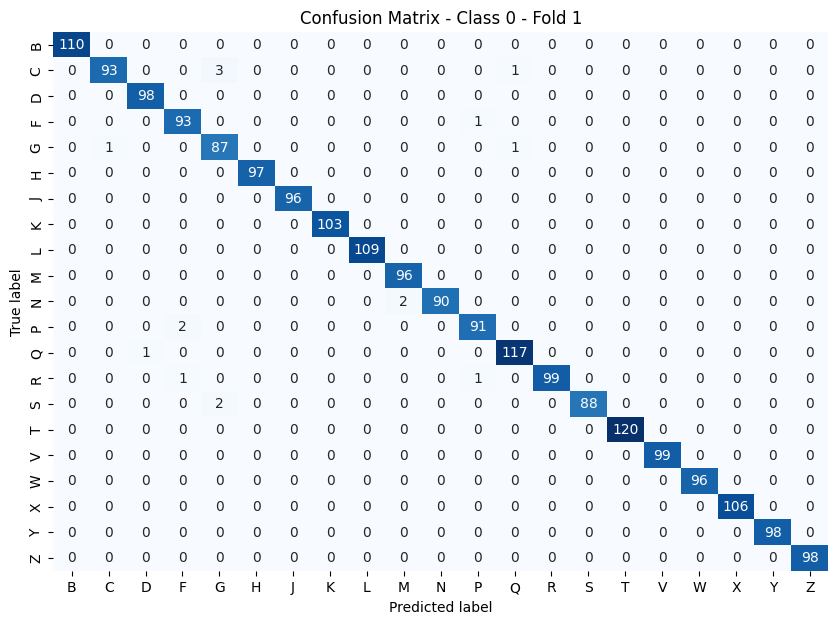

Clase 1 - Fold 1:
TP: 93, FP: 1, FN: 4, TN: 2002


<Figure size 640x480 with 0 Axes>

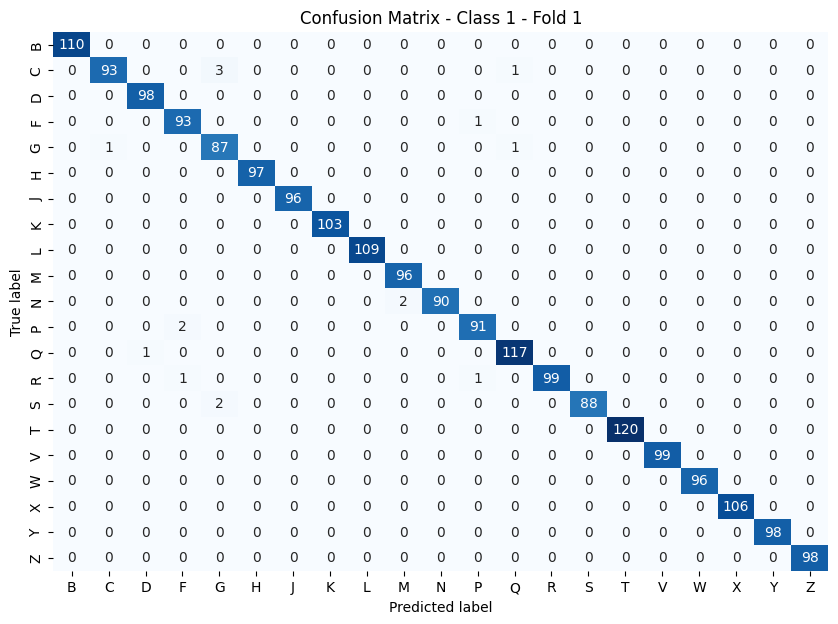

Clase 2 - Fold 1:
TP: 98, FP: 1, FN: 0, TN: 2001


<Figure size 640x480 with 0 Axes>

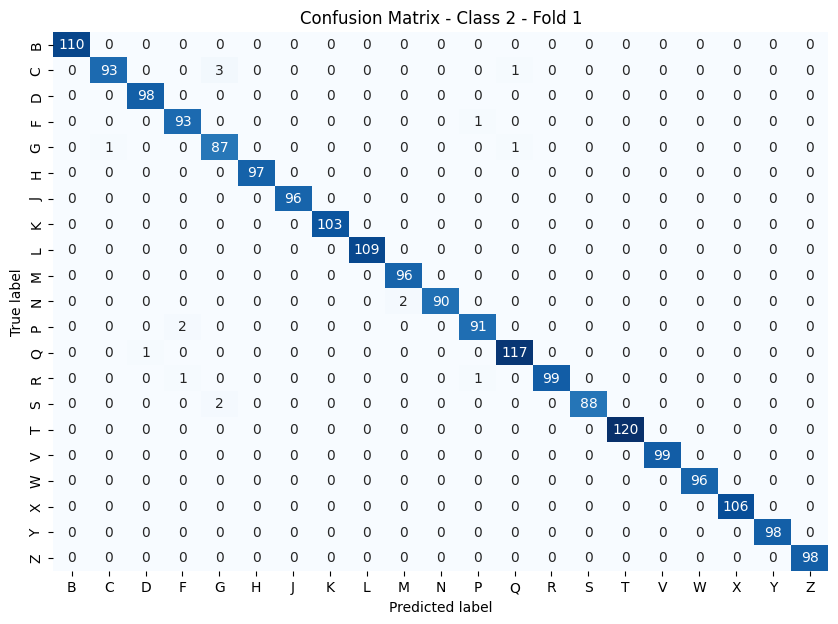

Clase 3 - Fold 1:
TP: 93, FP: 3, FN: 1, TN: 2003


<Figure size 640x480 with 0 Axes>

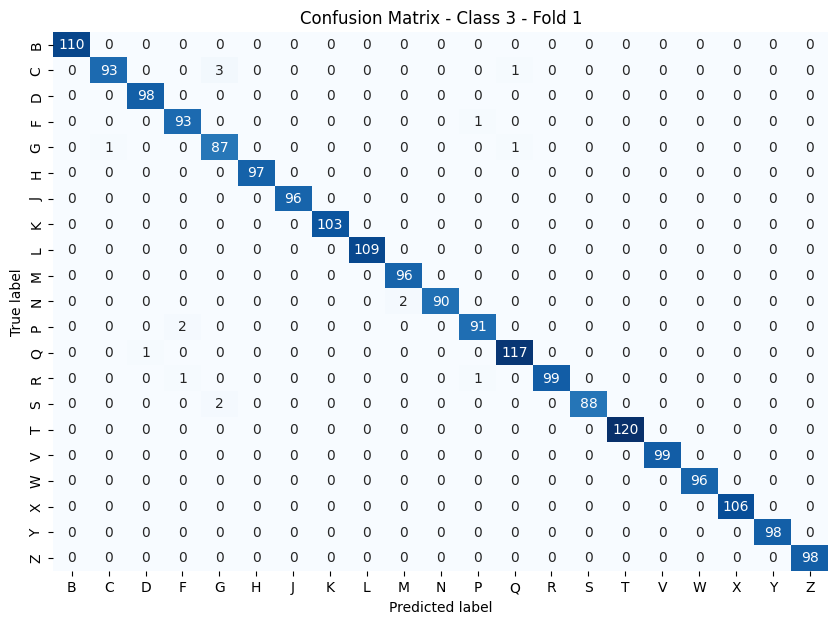

Clase 4 - Fold 1:
TP: 87, FP: 5, FN: 2, TN: 2006


<Figure size 640x480 with 0 Axes>

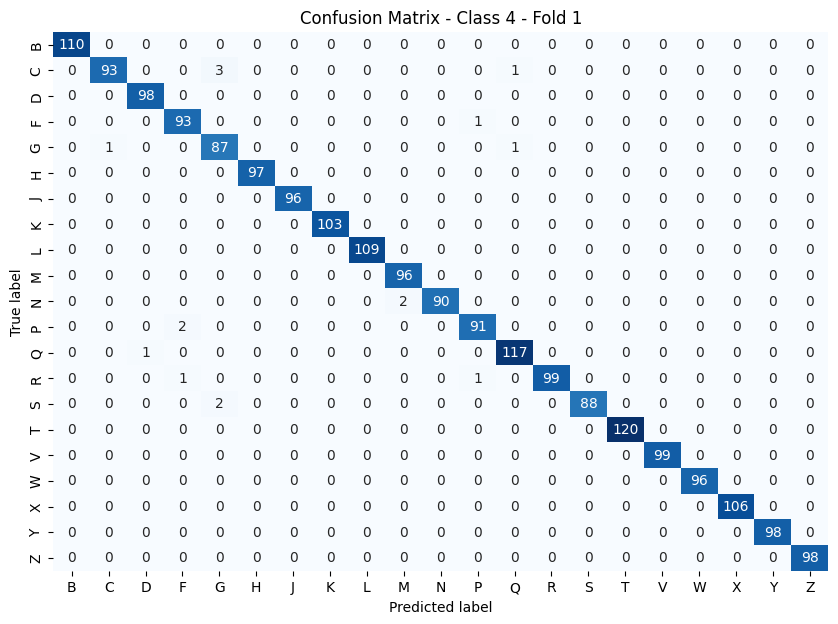

Clase 5 - Fold 1:
TP: 97, FP: 0, FN: 0, TN: 2003


<Figure size 640x480 with 0 Axes>

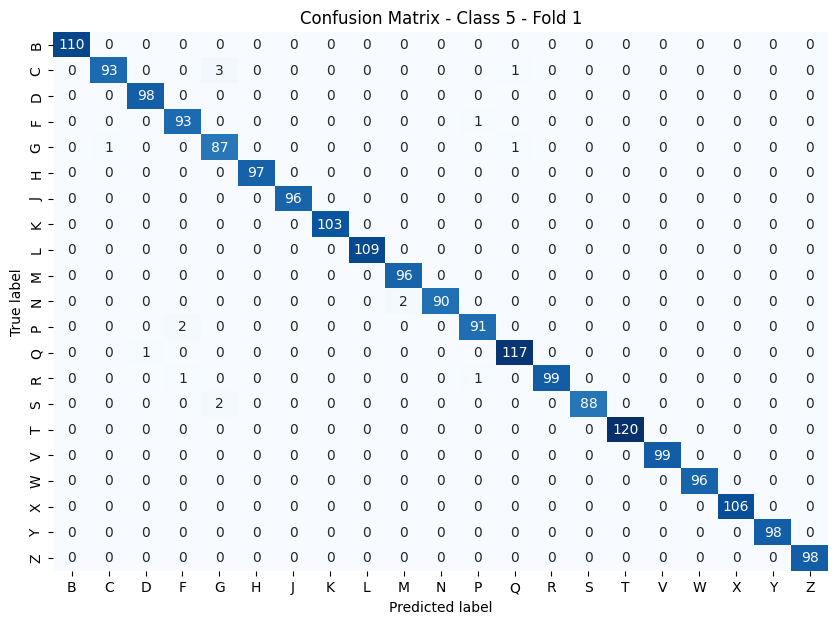

Clase 6 - Fold 1:
TP: 96, FP: 0, FN: 0, TN: 2004


<Figure size 640x480 with 0 Axes>

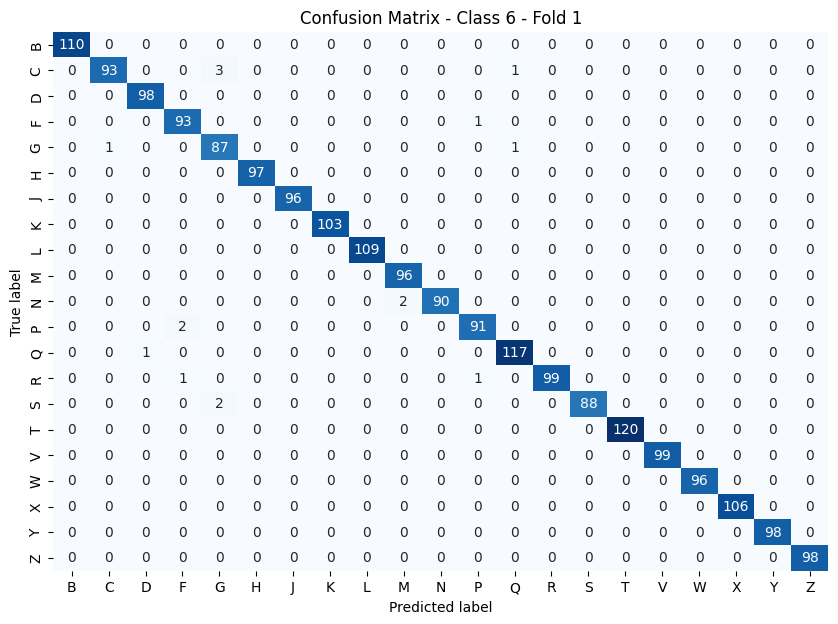

Clase 7 - Fold 1:
TP: 103, FP: 0, FN: 0, TN: 1997


<Figure size 640x480 with 0 Axes>

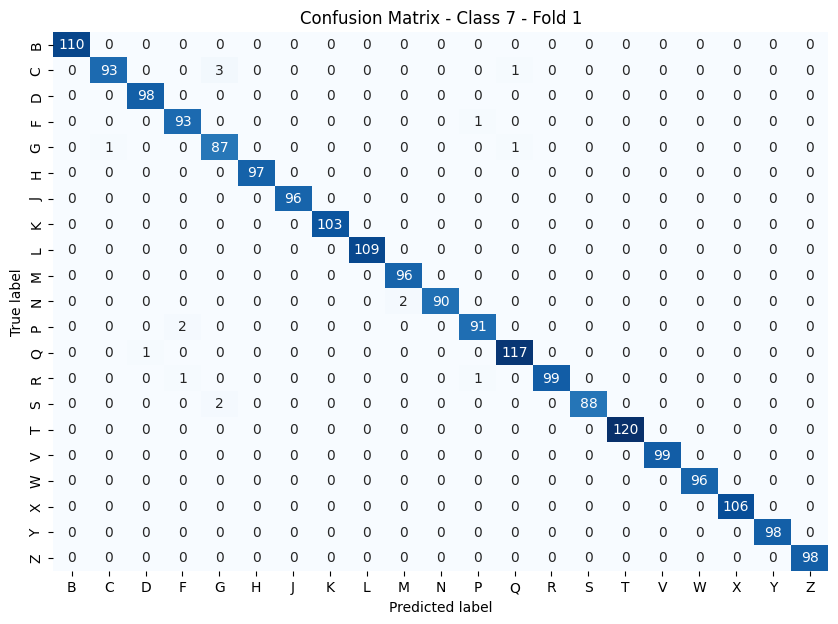

Clase 8 - Fold 1:
TP: 109, FP: 0, FN: 0, TN: 1991


<Figure size 640x480 with 0 Axes>

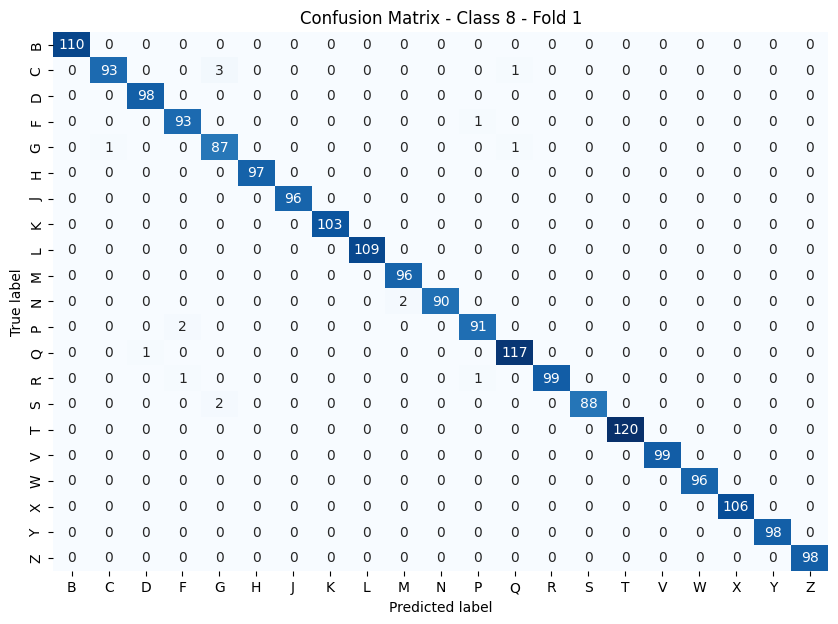

Clase 9 - Fold 1:
TP: 96, FP: 2, FN: 0, TN: 2002


<Figure size 640x480 with 0 Axes>

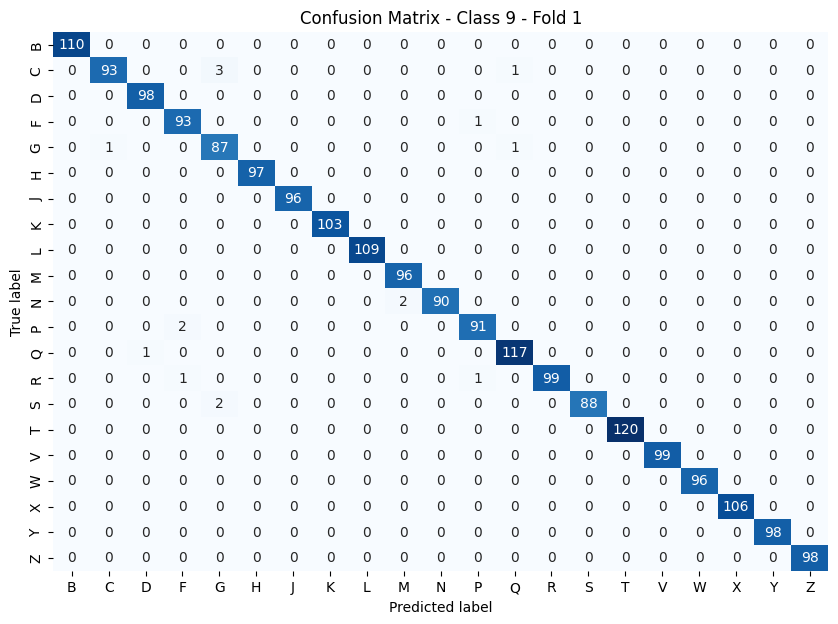

Clase 10 - Fold 1:
TP: 90, FP: 0, FN: 2, TN: 2008


<Figure size 640x480 with 0 Axes>

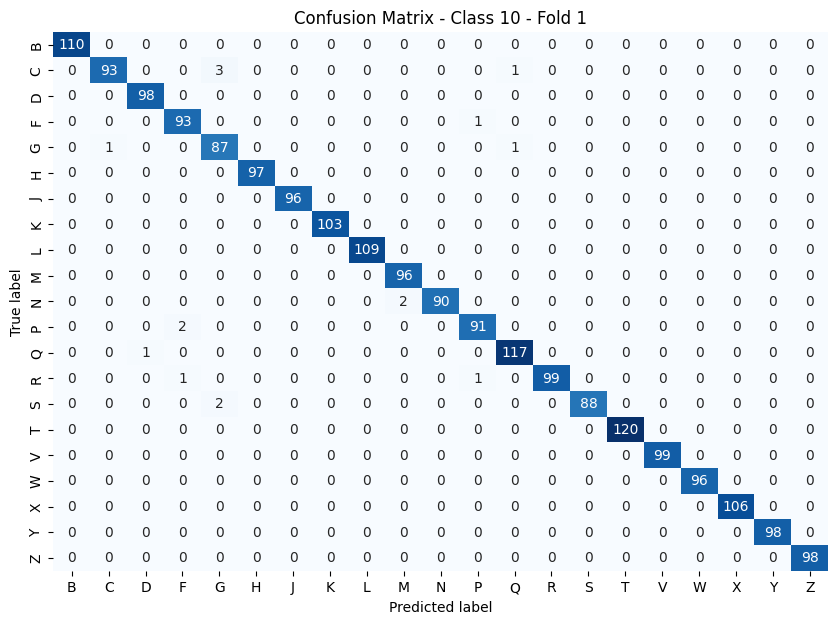

Clase 11 - Fold 1:
TP: 91, FP: 2, FN: 2, TN: 2005


<Figure size 640x480 with 0 Axes>

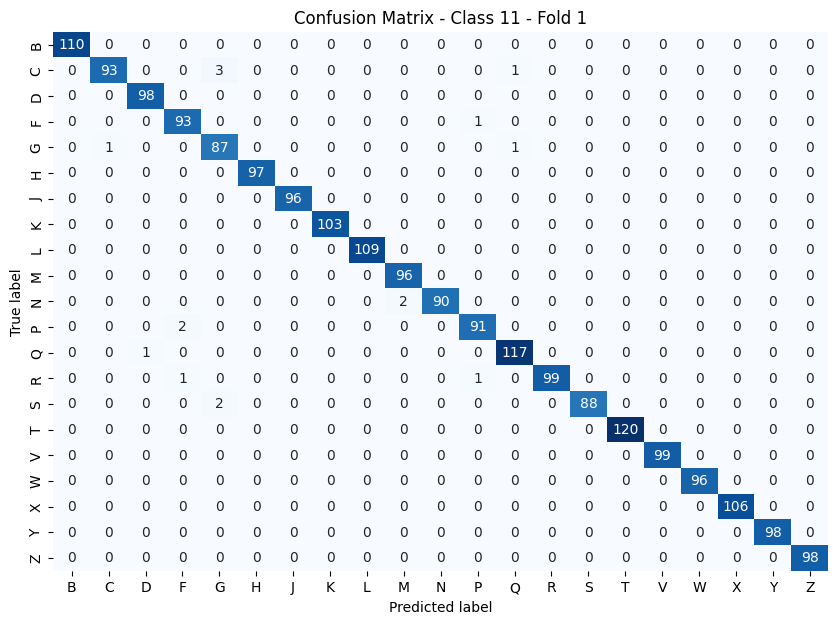

Clase 12 - Fold 1:
TP: 117, FP: 2, FN: 1, TN: 1980


<Figure size 640x480 with 0 Axes>

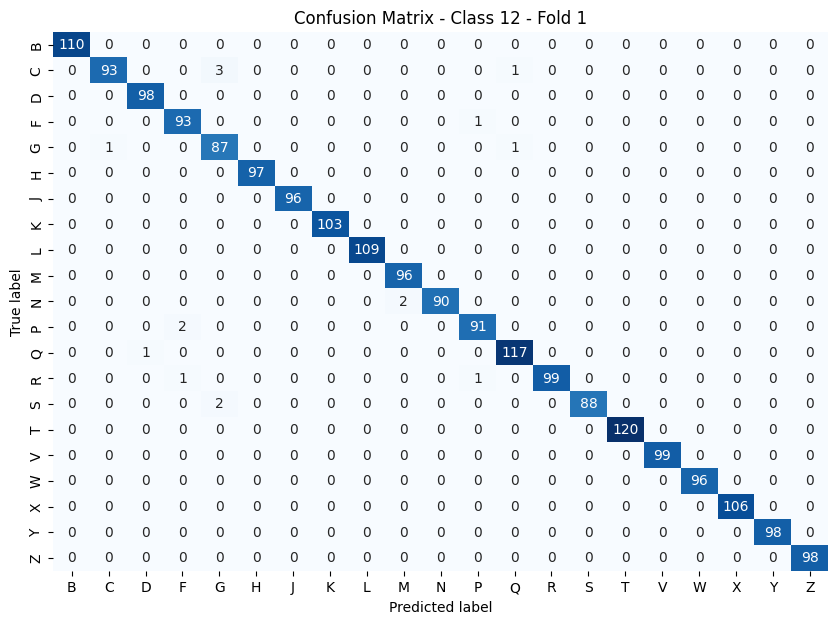

Clase 13 - Fold 1:
TP: 99, FP: 0, FN: 2, TN: 1999


<Figure size 640x480 with 0 Axes>

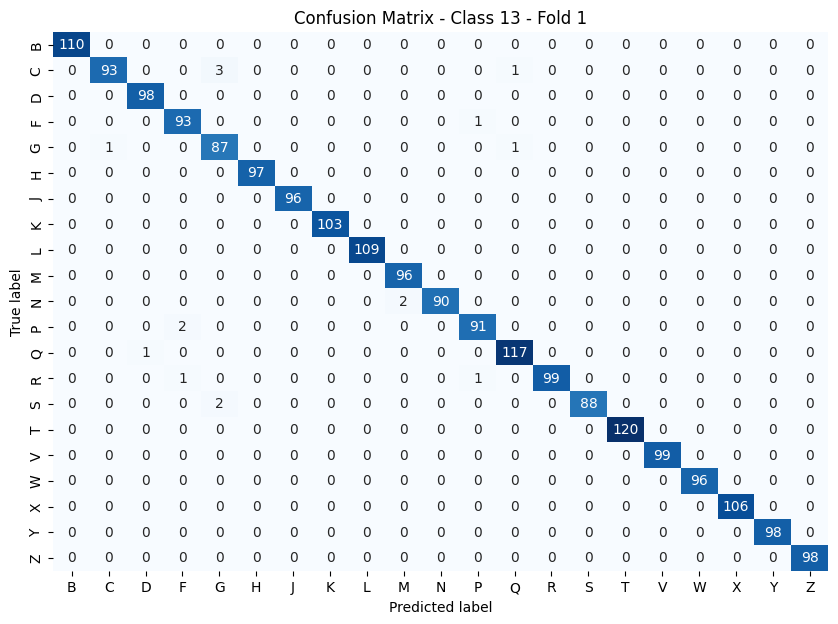

Clase 14 - Fold 1:
TP: 88, FP: 0, FN: 2, TN: 2010


<Figure size 640x480 with 0 Axes>

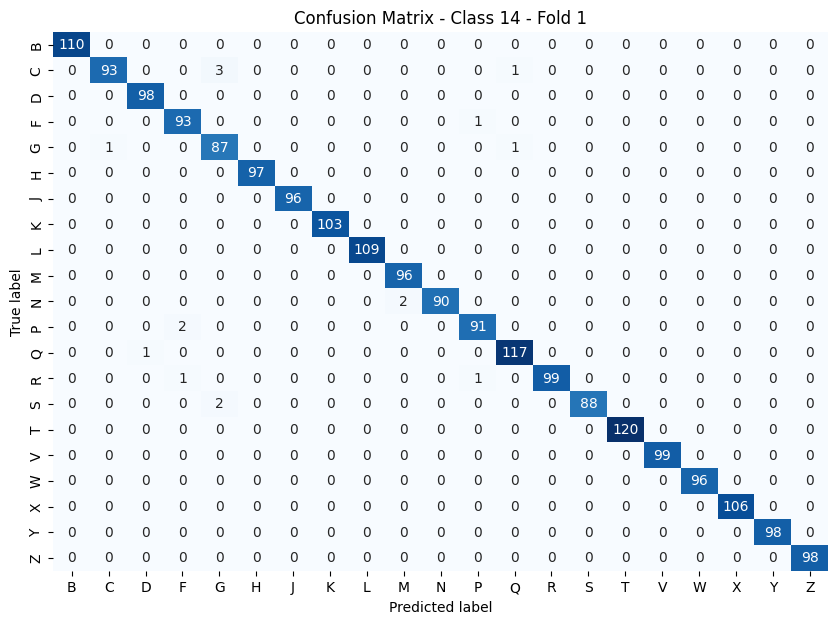

Clase 15 - Fold 1:
TP: 120, FP: 0, FN: 0, TN: 1980


<Figure size 640x480 with 0 Axes>

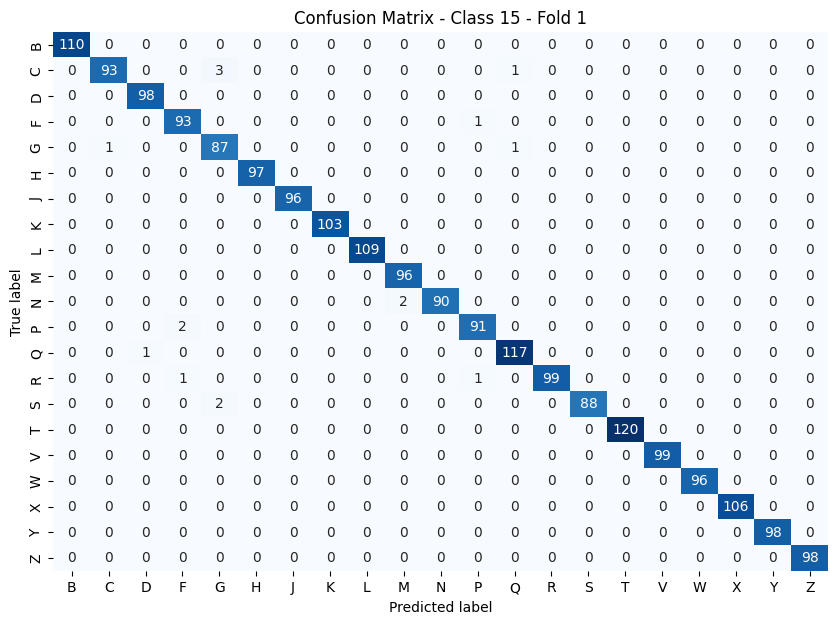

Clase 16 - Fold 1:
TP: 99, FP: 0, FN: 0, TN: 2001


<Figure size 640x480 with 0 Axes>

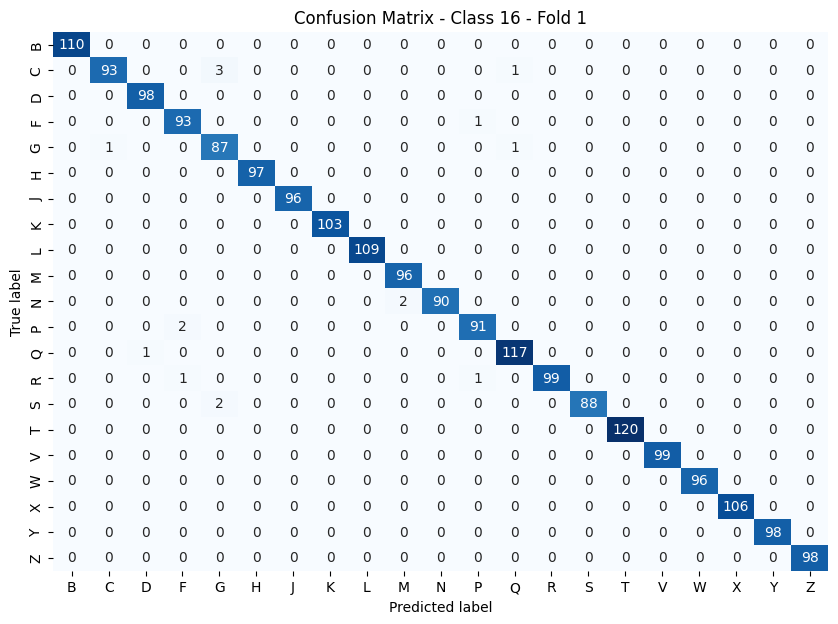

Clase 17 - Fold 1:
TP: 96, FP: 0, FN: 0, TN: 2004


<Figure size 640x480 with 0 Axes>

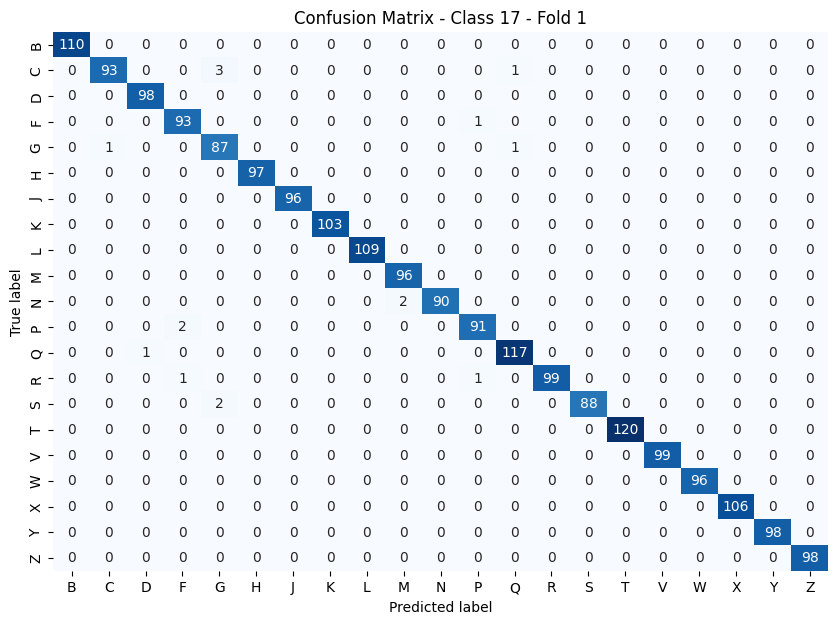

Clase 18 - Fold 1:
TP: 106, FP: 0, FN: 0, TN: 1994


<Figure size 640x480 with 0 Axes>

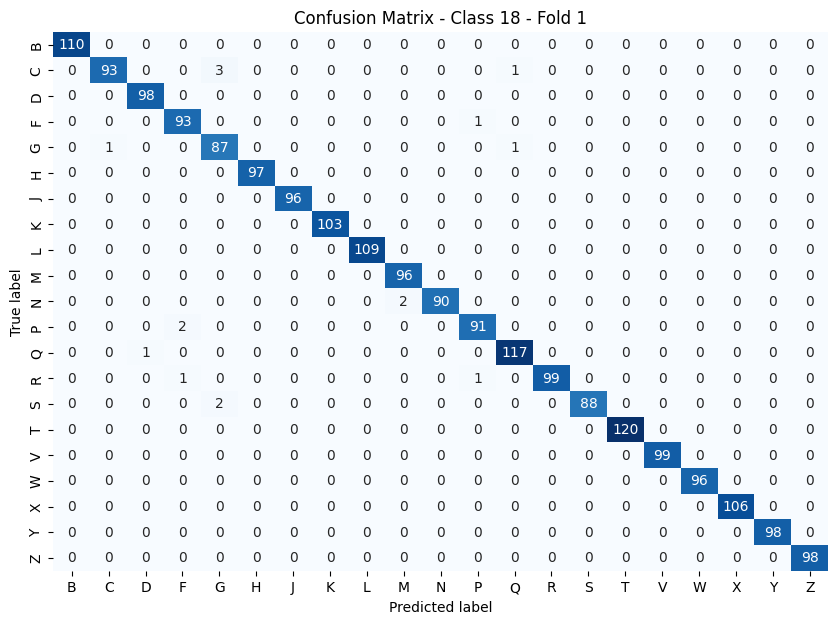

Clase 19 - Fold 1:
TP: 98, FP: 0, FN: 0, TN: 2002


<Figure size 640x480 with 0 Axes>

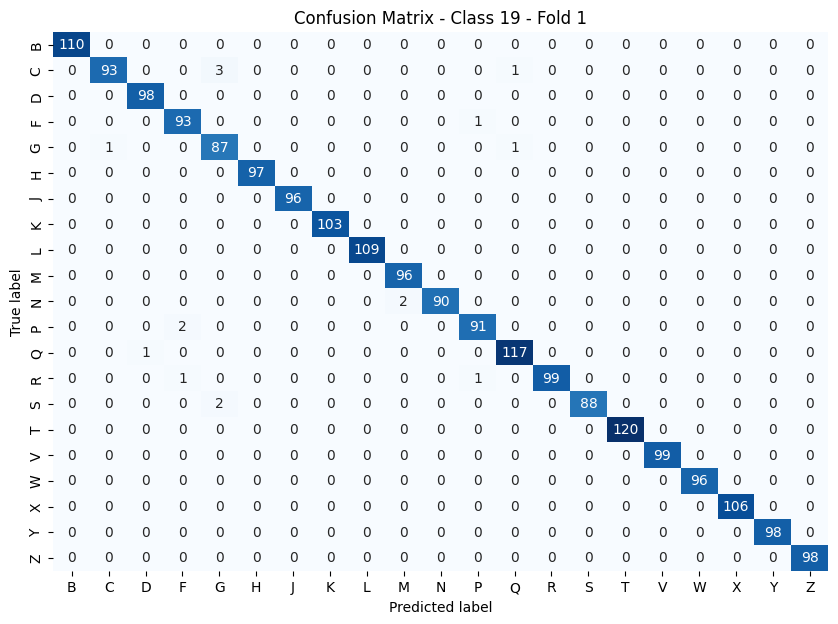

Clase 20 - Fold 1:
TP: 98, FP: 0, FN: 0, TN: 2002


<Figure size 640x480 with 0 Axes>

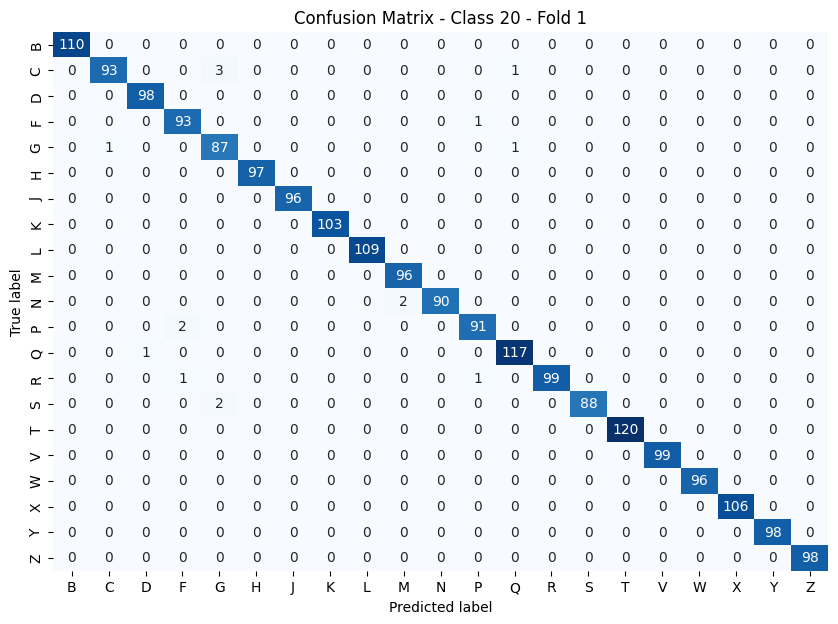

Fold 2/5
Clase 0 - Fold 2:
TP: 105, FP: 0, FN: 1, TN: 1994


<Figure size 640x480 with 0 Axes>

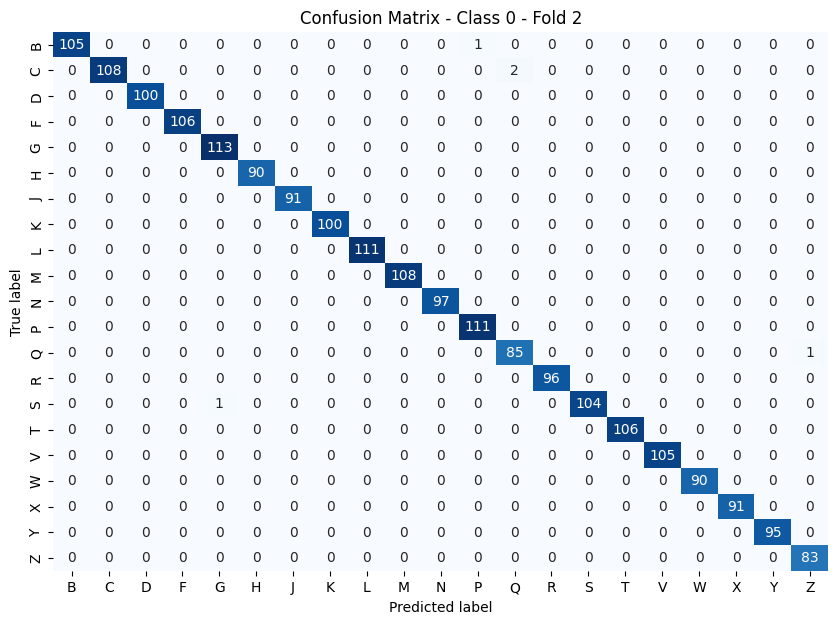

Clase 1 - Fold 2:
TP: 108, FP: 0, FN: 2, TN: 1990


<Figure size 640x480 with 0 Axes>

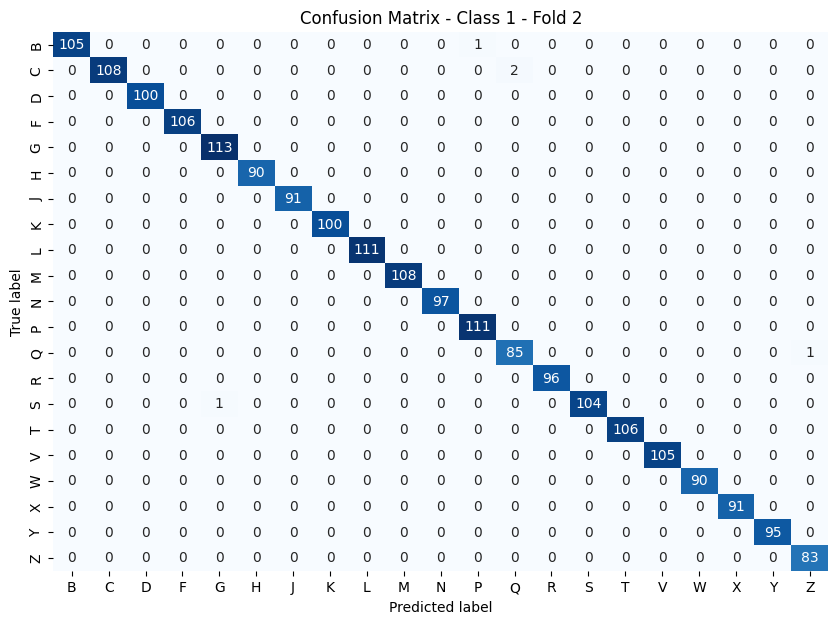

Clase 2 - Fold 2:
TP: 100, FP: 0, FN: 0, TN: 2000


<Figure size 640x480 with 0 Axes>

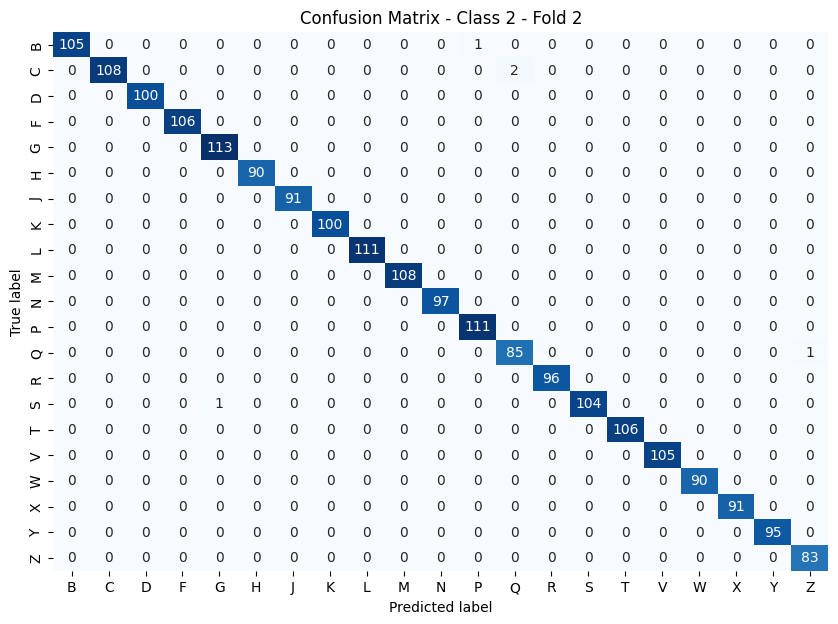

Clase 3 - Fold 2:
TP: 106, FP: 0, FN: 0, TN: 1994


<Figure size 640x480 with 0 Axes>

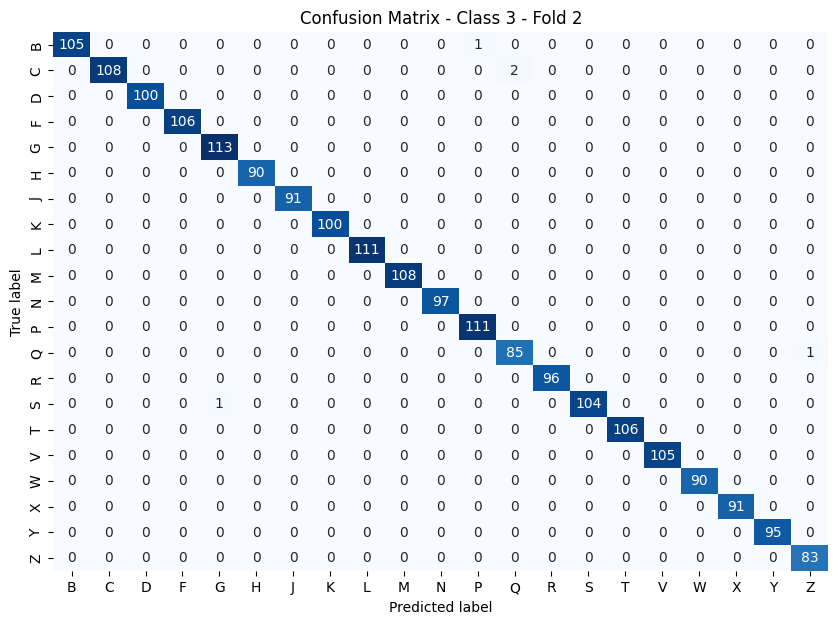

Clase 4 - Fold 2:
TP: 113, FP: 1, FN: 0, TN: 1986


<Figure size 640x480 with 0 Axes>

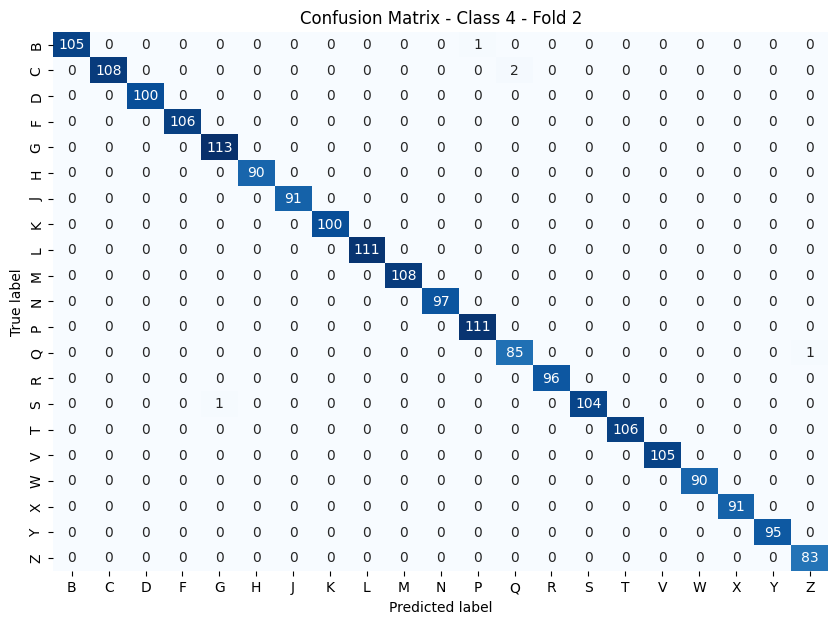

Clase 5 - Fold 2:
TP: 90, FP: 0, FN: 0, TN: 2010


<Figure size 640x480 with 0 Axes>

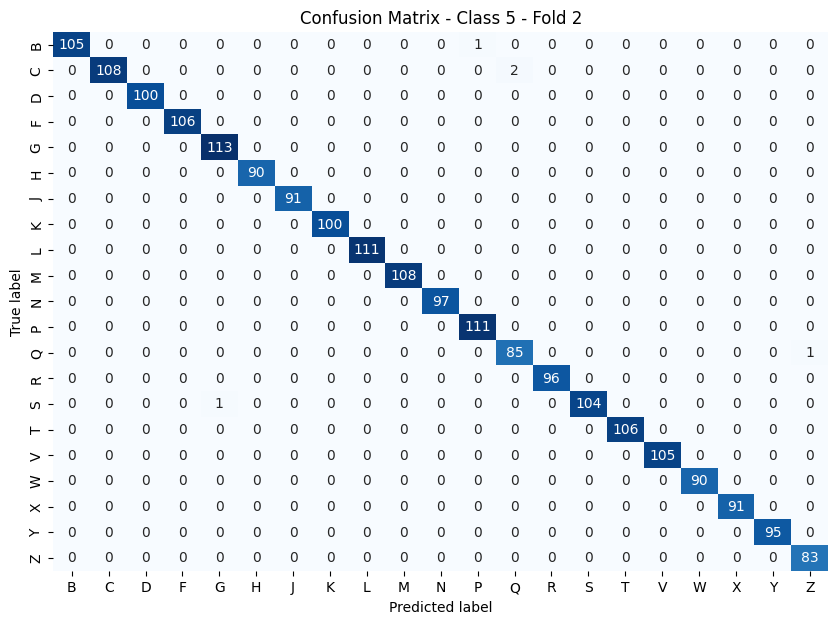

Clase 6 - Fold 2:
TP: 91, FP: 0, FN: 0, TN: 2009


<Figure size 640x480 with 0 Axes>

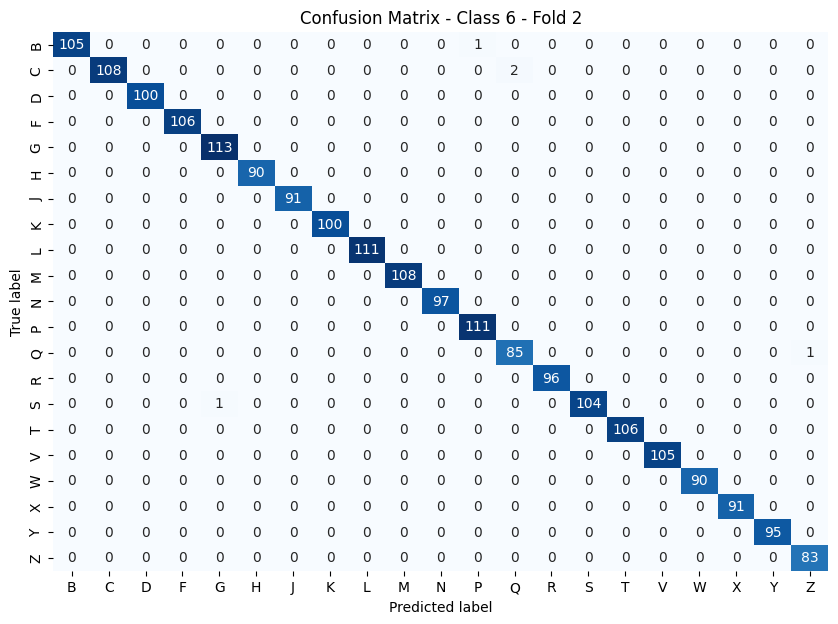

Clase 7 - Fold 2:
TP: 100, FP: 0, FN: 0, TN: 2000


<Figure size 640x480 with 0 Axes>

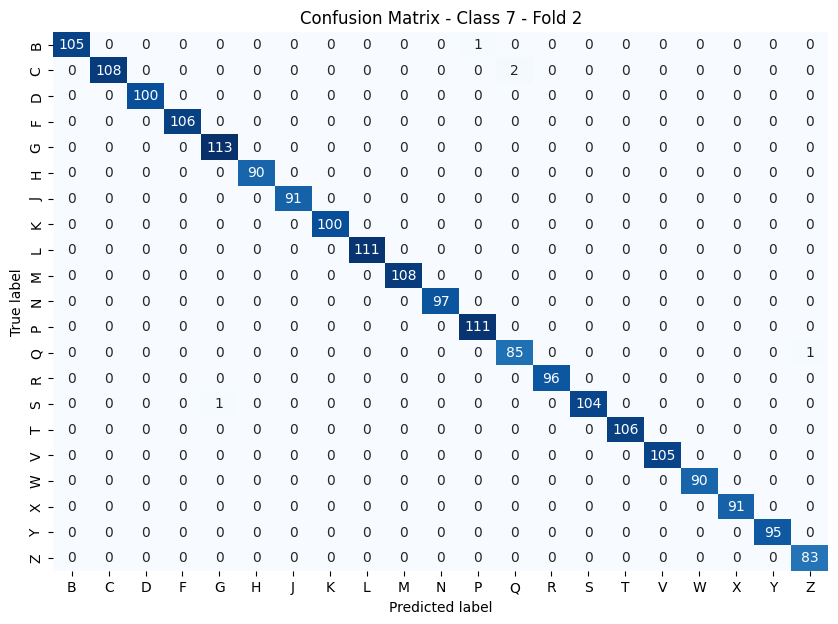

Clase 8 - Fold 2:
TP: 111, FP: 0, FN: 0, TN: 1989


<Figure size 640x480 with 0 Axes>

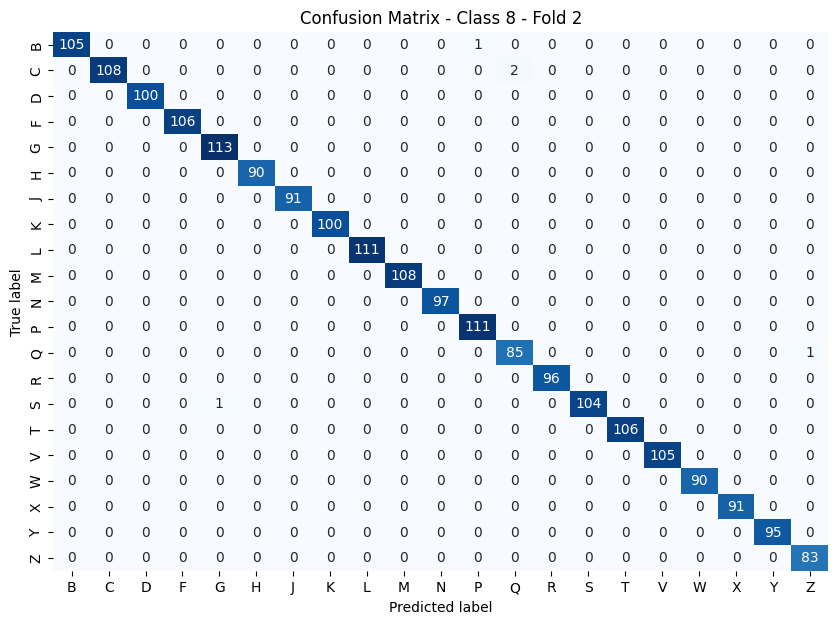

Clase 9 - Fold 2:
TP: 108, FP: 0, FN: 0, TN: 1992


<Figure size 640x480 with 0 Axes>

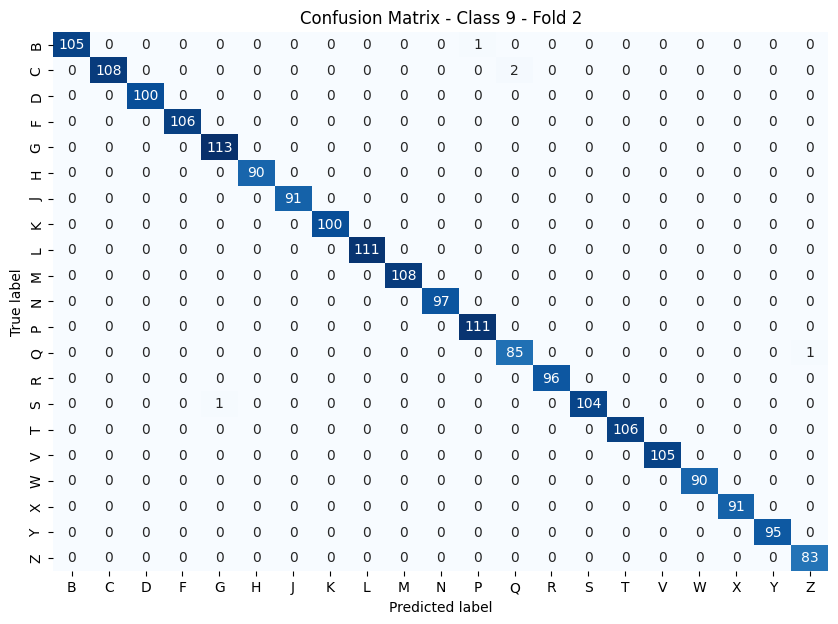

Clase 10 - Fold 2:
TP: 97, FP: 0, FN: 0, TN: 2003


<Figure size 640x480 with 0 Axes>

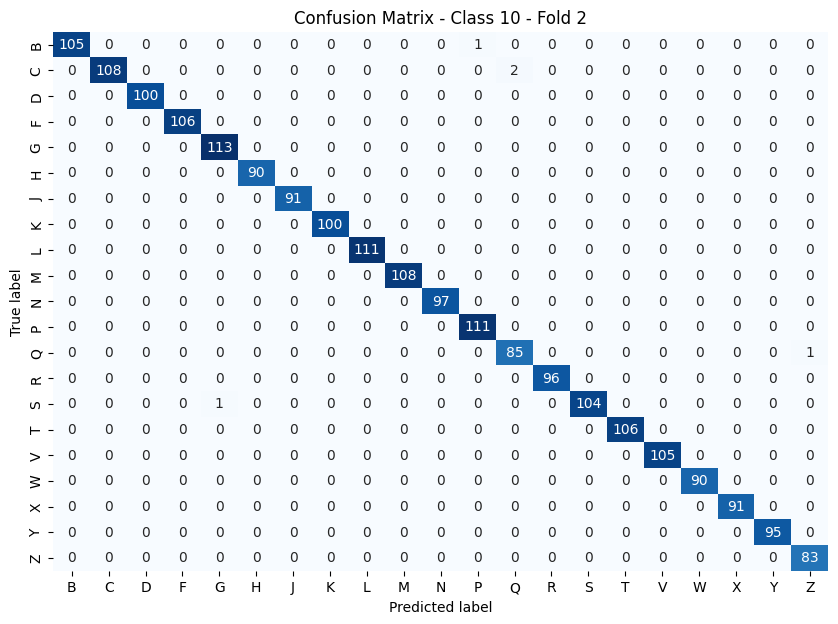

Clase 11 - Fold 2:
TP: 111, FP: 1, FN: 0, TN: 1988


<Figure size 640x480 with 0 Axes>

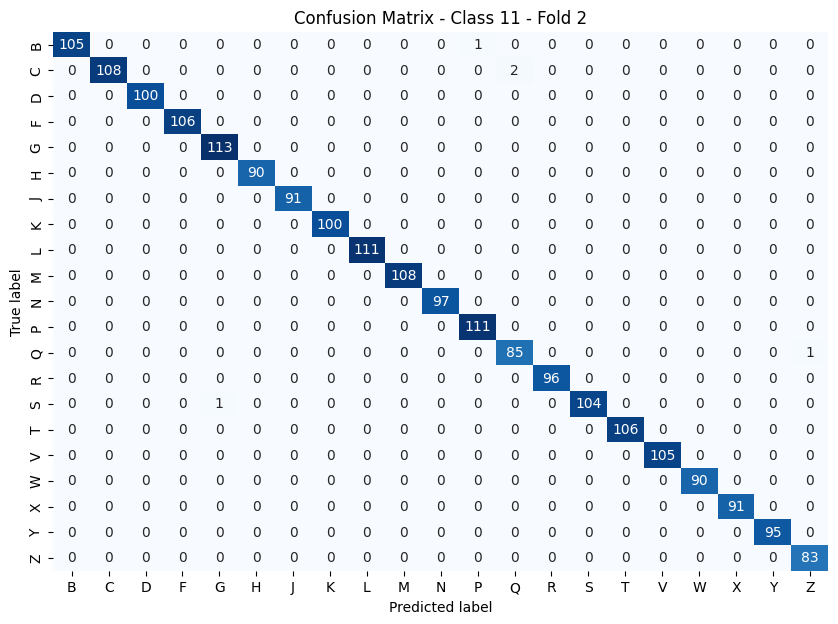

Clase 12 - Fold 2:
TP: 85, FP: 2, FN: 1, TN: 2012


<Figure size 640x480 with 0 Axes>

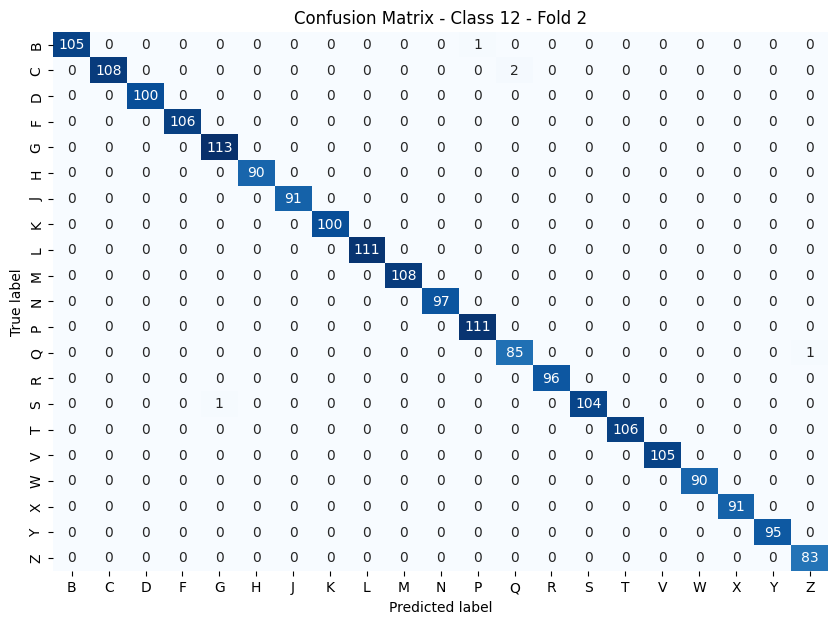

Clase 13 - Fold 2:
TP: 96, FP: 0, FN: 0, TN: 2004


<Figure size 640x480 with 0 Axes>

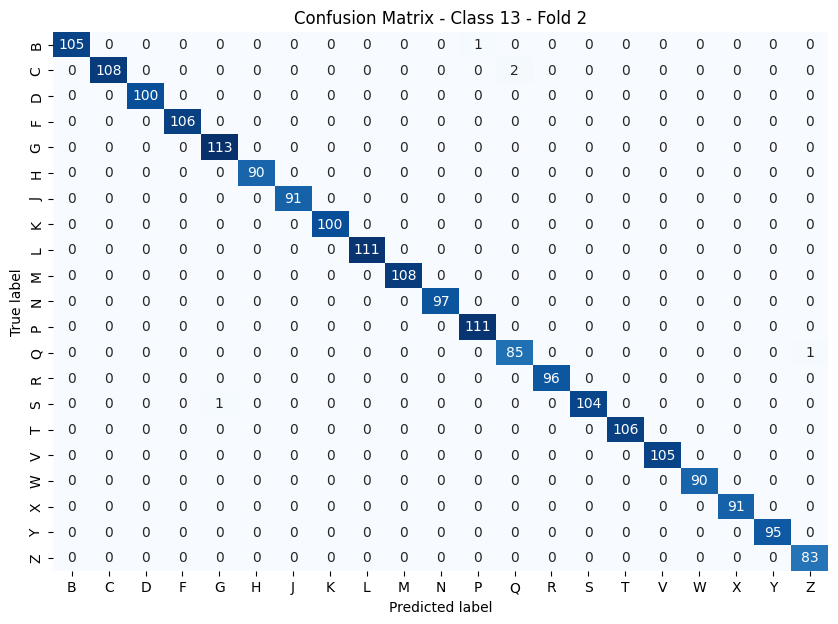

Clase 14 - Fold 2:
TP: 104, FP: 0, FN: 1, TN: 1995


<Figure size 640x480 with 0 Axes>

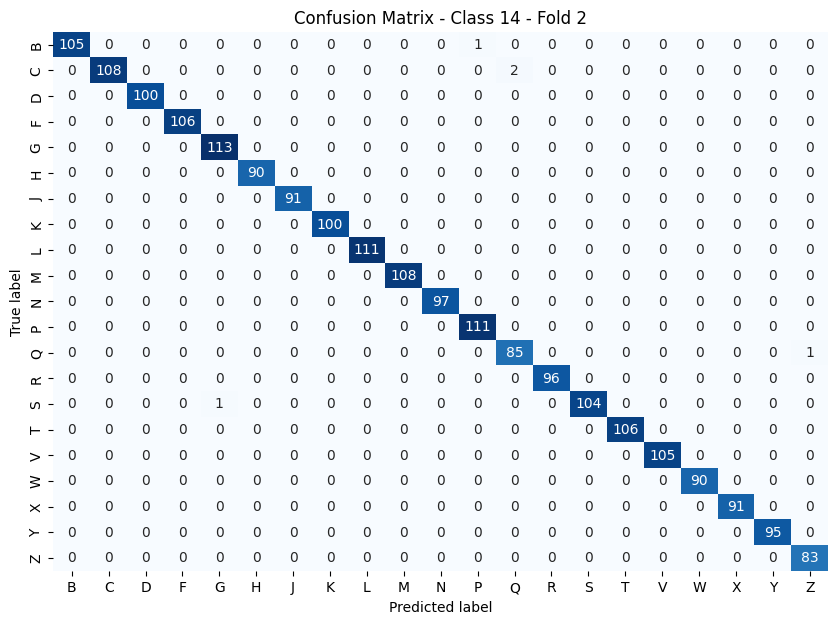

Clase 15 - Fold 2:
TP: 106, FP: 0, FN: 0, TN: 1994


<Figure size 640x480 with 0 Axes>

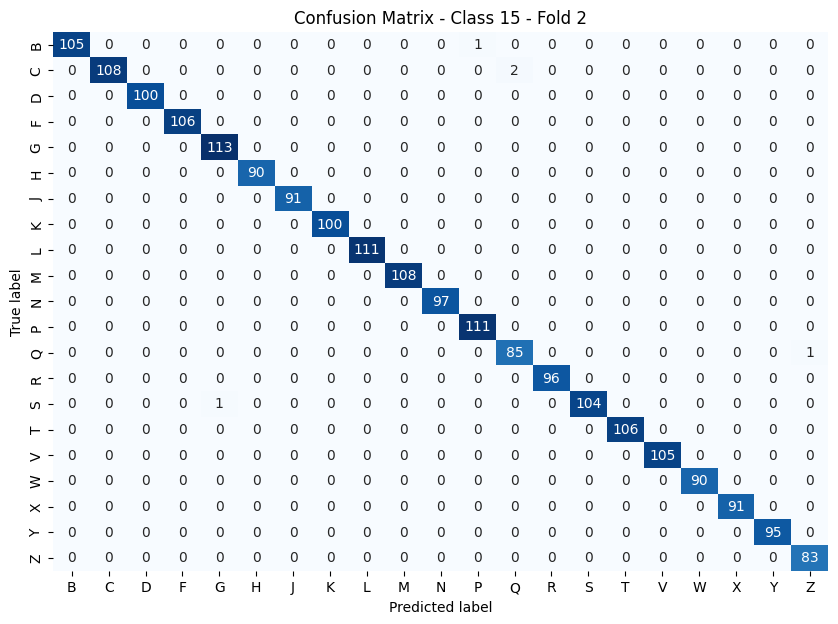

Clase 16 - Fold 2:
TP: 105, FP: 0, FN: 0, TN: 1995


<Figure size 640x480 with 0 Axes>

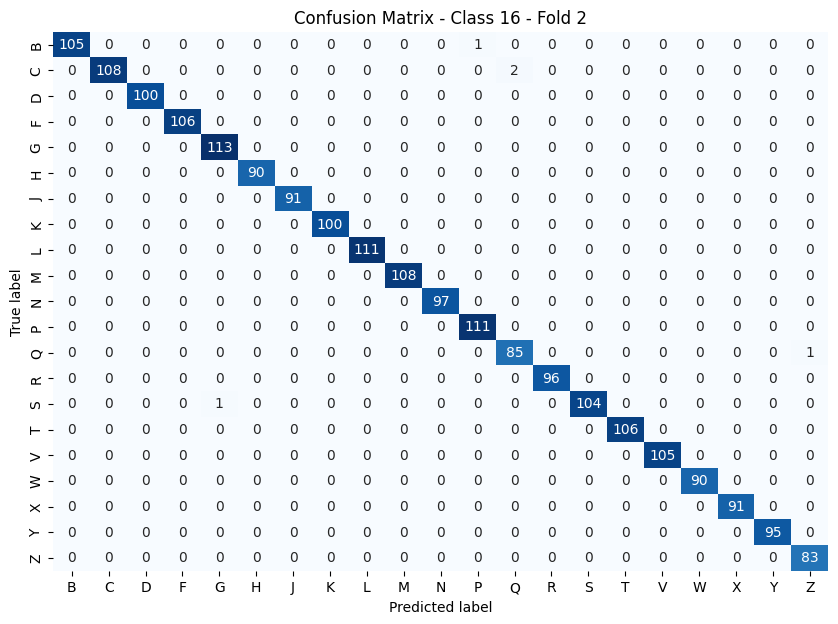

Clase 17 - Fold 2:
TP: 90, FP: 0, FN: 0, TN: 2010


<Figure size 640x480 with 0 Axes>

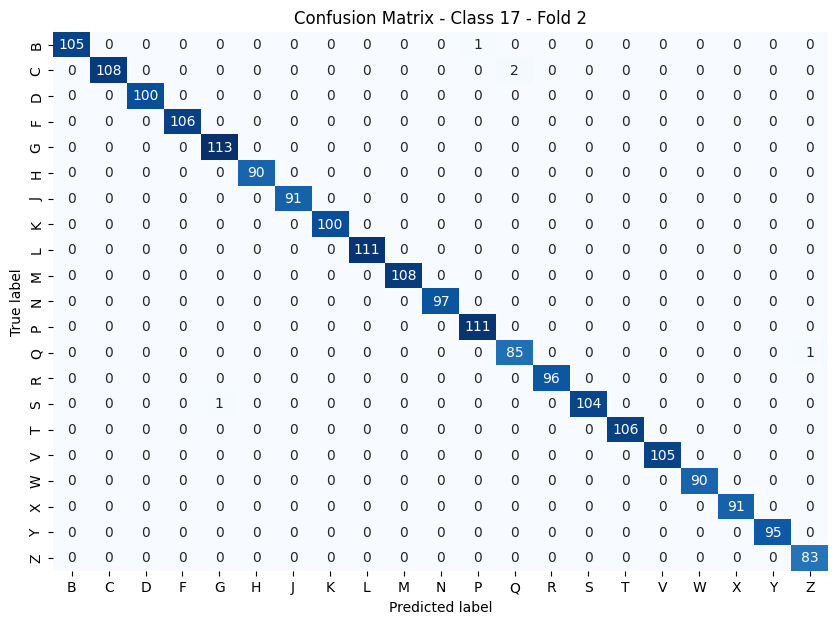

Clase 18 - Fold 2:
TP: 91, FP: 0, FN: 0, TN: 2009


<Figure size 640x480 with 0 Axes>

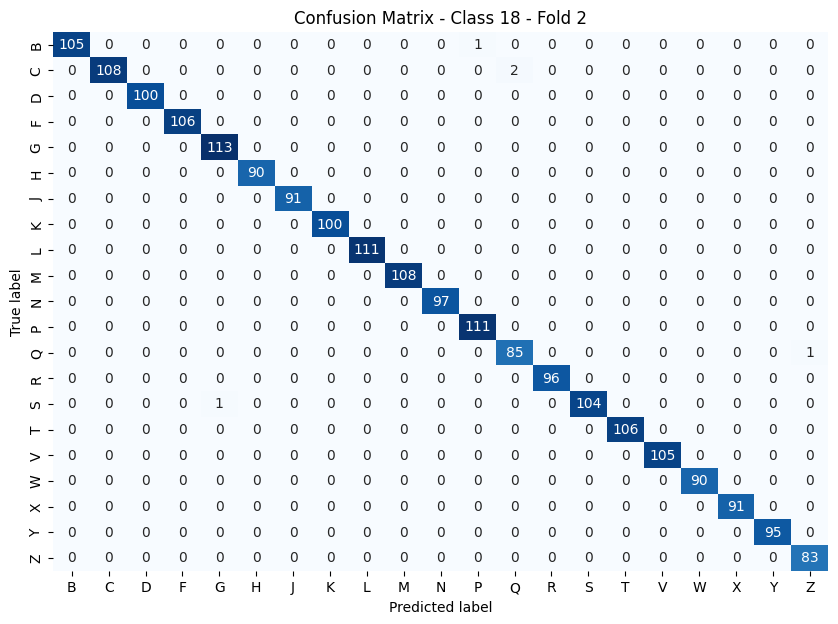

Clase 19 - Fold 2:
TP: 95, FP: 0, FN: 0, TN: 2005


<Figure size 640x480 with 0 Axes>

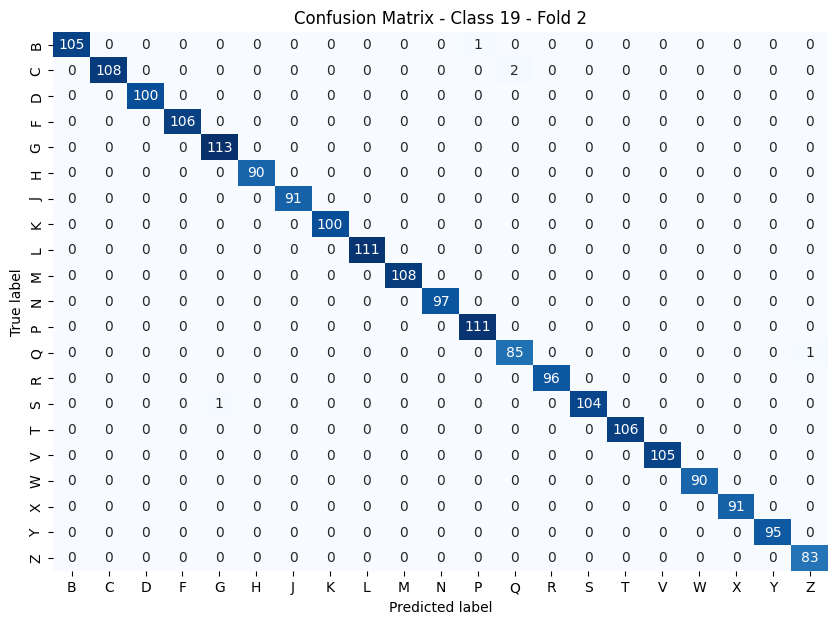

Clase 20 - Fold 2:
TP: 83, FP: 1, FN: 0, TN: 2016


<Figure size 640x480 with 0 Axes>

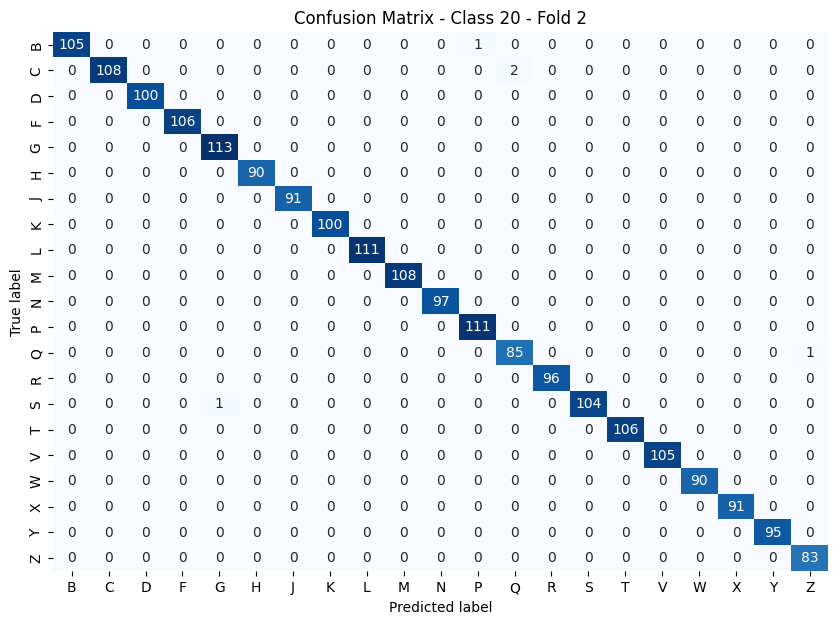

Fold 3/5
Clase 0 - Fold 3:
TP: 96, FP: 0, FN: 0, TN: 2004


<Figure size 640x480 with 0 Axes>

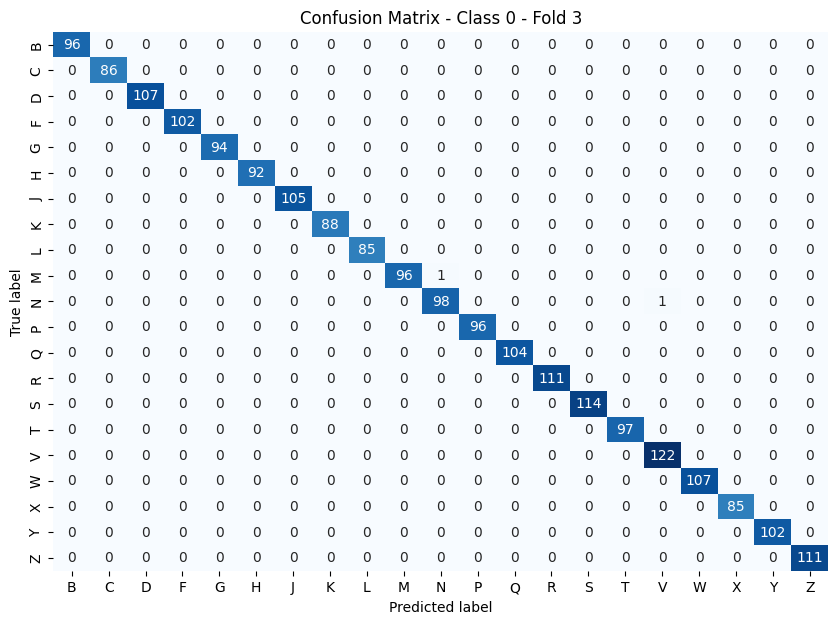

Clase 1 - Fold 3:
TP: 86, FP: 0, FN: 0, TN: 2014


<Figure size 640x480 with 0 Axes>

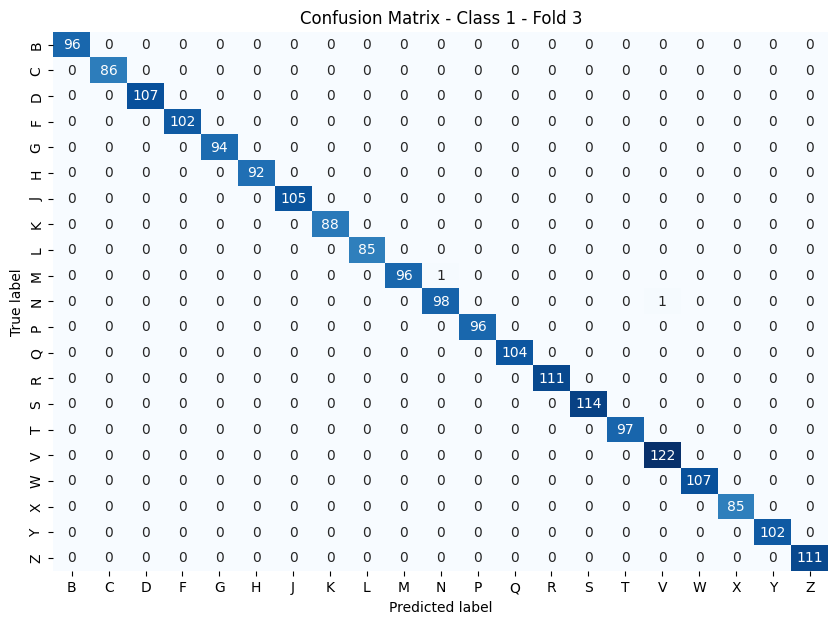

Clase 2 - Fold 3:
TP: 107, FP: 0, FN: 0, TN: 1993


<Figure size 640x480 with 0 Axes>

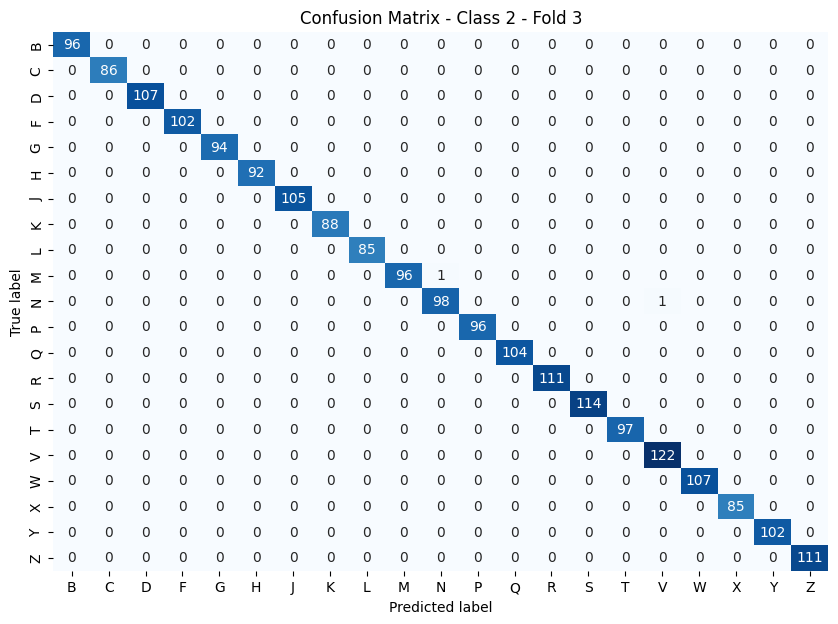

Clase 3 - Fold 3:
TP: 102, FP: 0, FN: 0, TN: 1998


<Figure size 640x480 with 0 Axes>

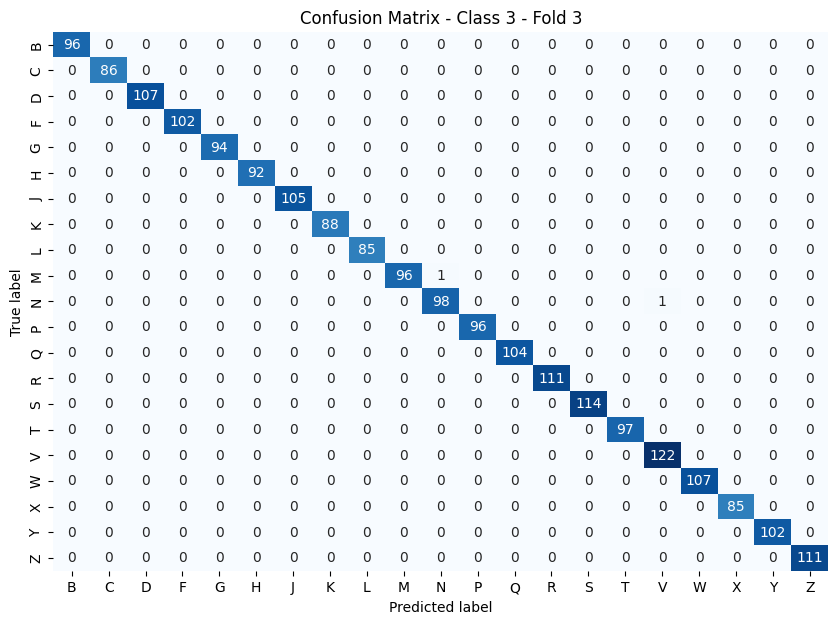

Clase 4 - Fold 3:
TP: 94, FP: 0, FN: 0, TN: 2006


<Figure size 640x480 with 0 Axes>

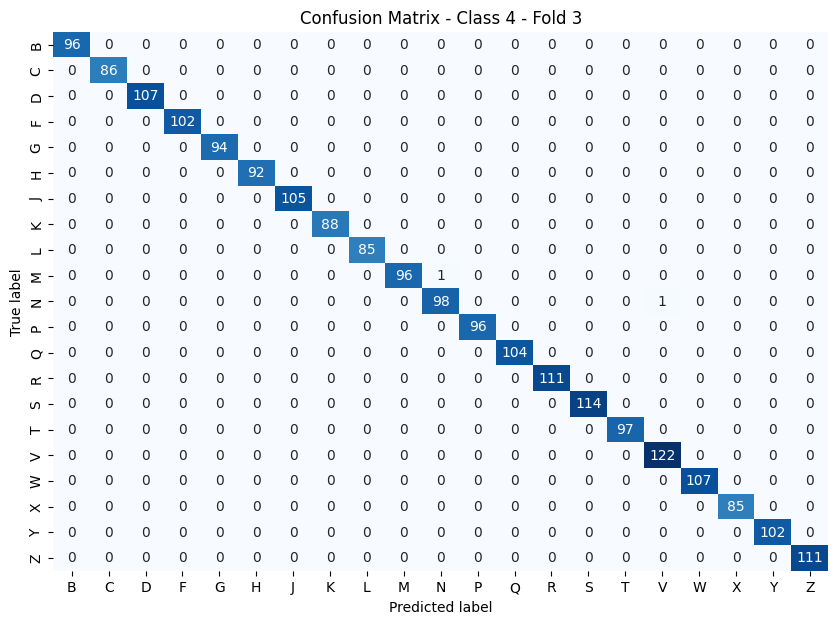

Clase 5 - Fold 3:
TP: 92, FP: 0, FN: 0, TN: 2008


<Figure size 640x480 with 0 Axes>

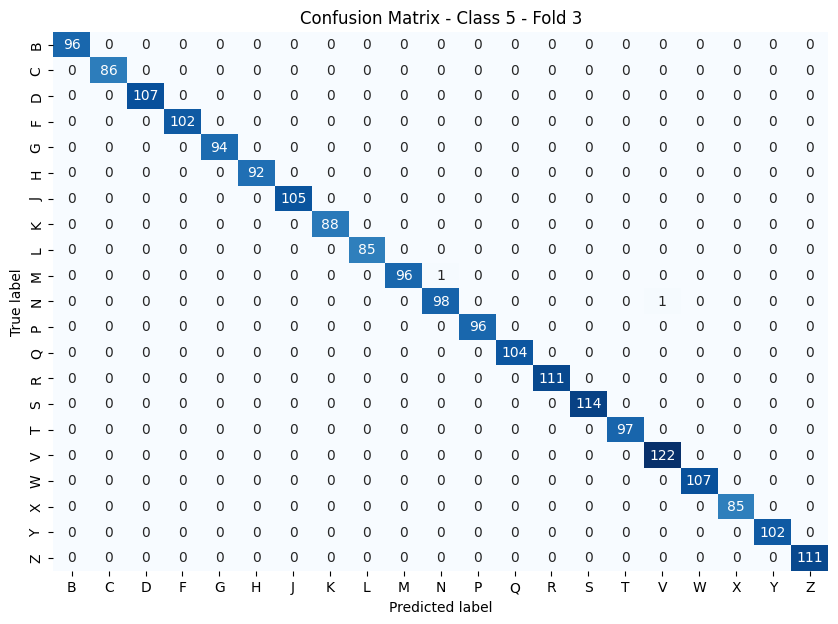

Clase 6 - Fold 3:
TP: 105, FP: 0, FN: 0, TN: 1995


<Figure size 640x480 with 0 Axes>

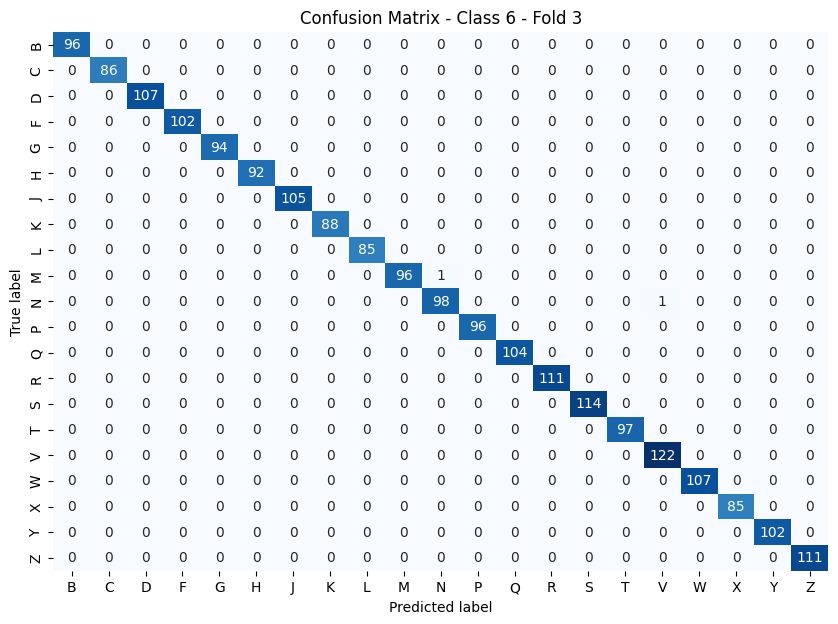

Clase 7 - Fold 3:
TP: 88, FP: 0, FN: 0, TN: 2012


<Figure size 640x480 with 0 Axes>

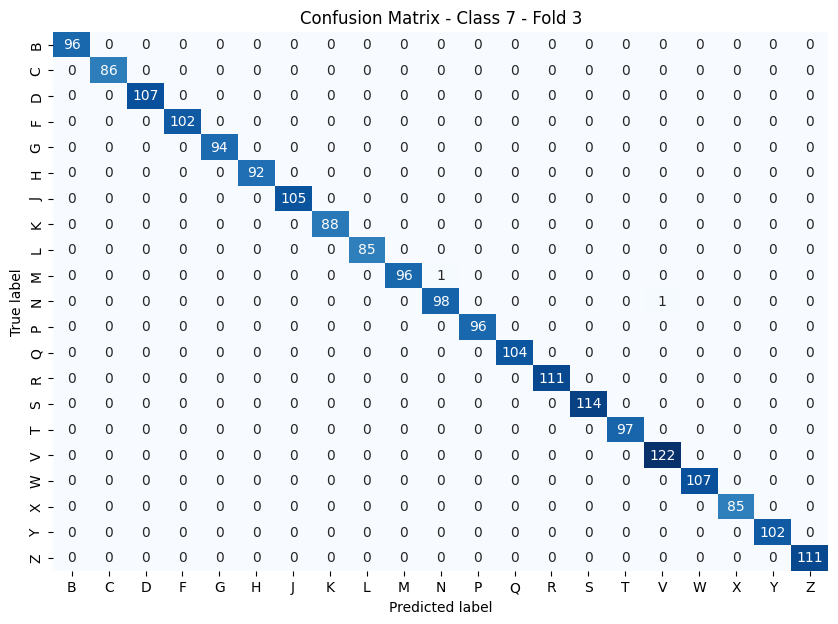

Clase 8 - Fold 3:
TP: 85, FP: 0, FN: 0, TN: 2015


<Figure size 640x480 with 0 Axes>

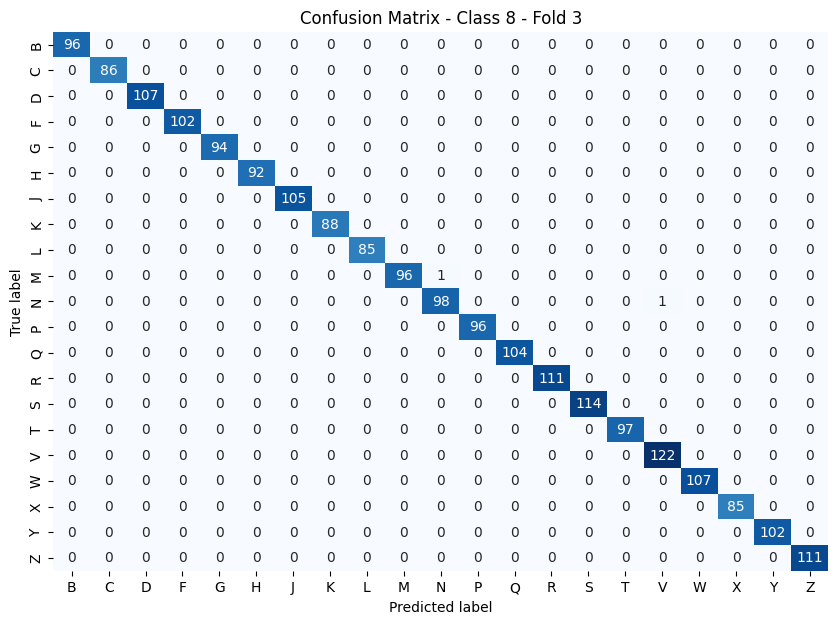

Clase 9 - Fold 3:
TP: 96, FP: 0, FN: 1, TN: 2003


<Figure size 640x480 with 0 Axes>

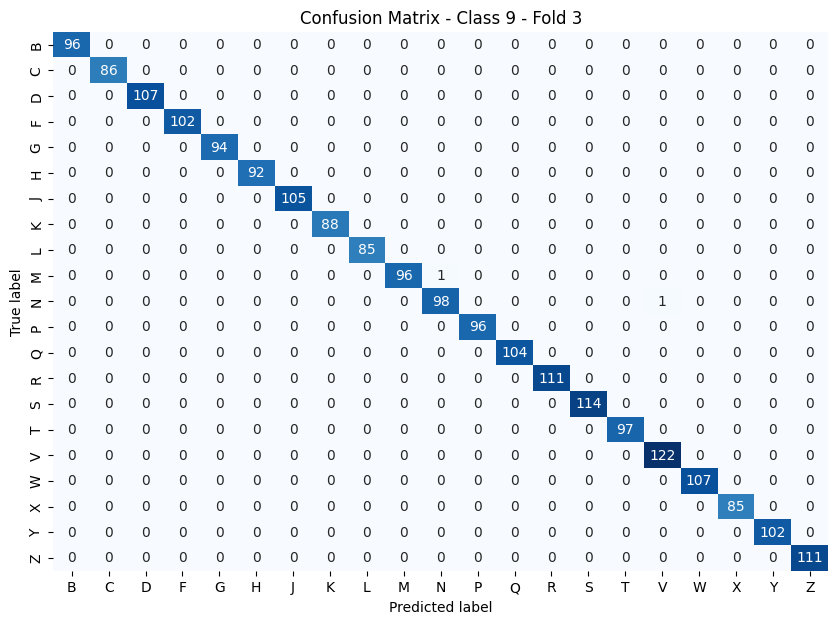

Clase 10 - Fold 3:
TP: 98, FP: 1, FN: 1, TN: 2000


<Figure size 640x480 with 0 Axes>

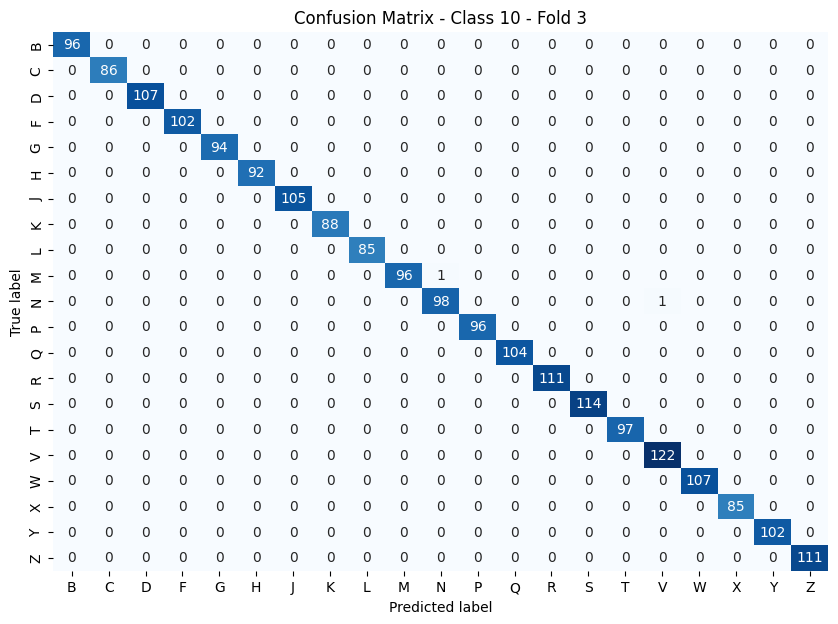

Clase 11 - Fold 3:
TP: 96, FP: 0, FN: 0, TN: 2004


<Figure size 640x480 with 0 Axes>

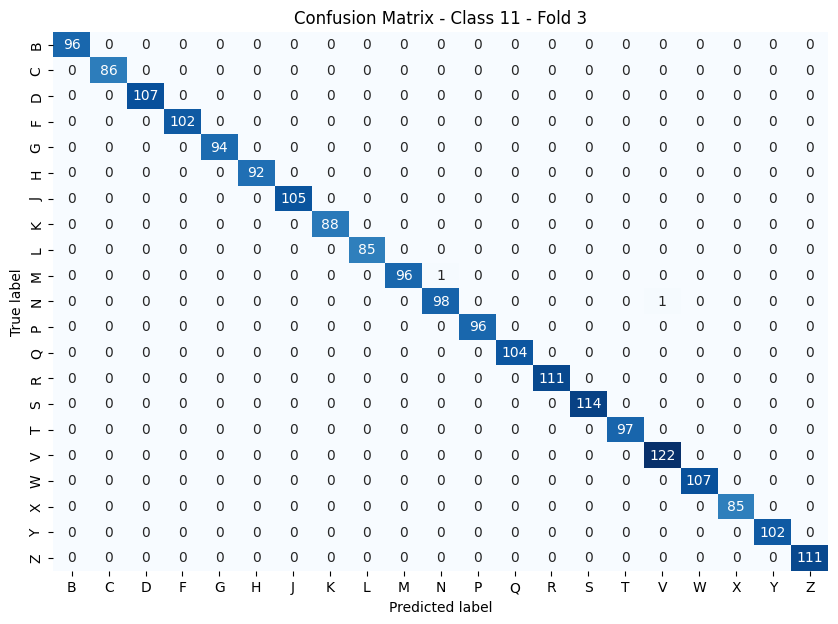

Clase 12 - Fold 3:
TP: 104, FP: 0, FN: 0, TN: 1996


<Figure size 640x480 with 0 Axes>

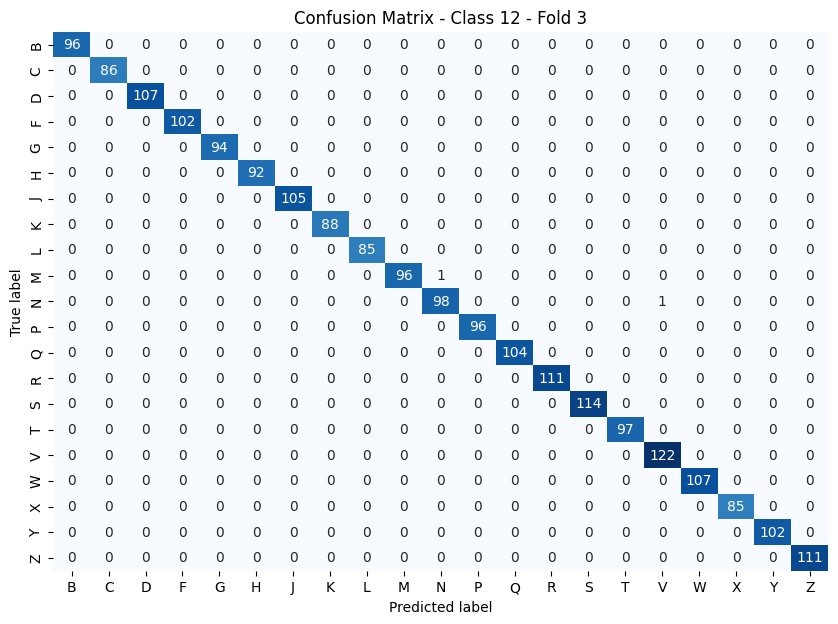

Clase 13 - Fold 3:
TP: 111, FP: 0, FN: 0, TN: 1989


<Figure size 640x480 with 0 Axes>

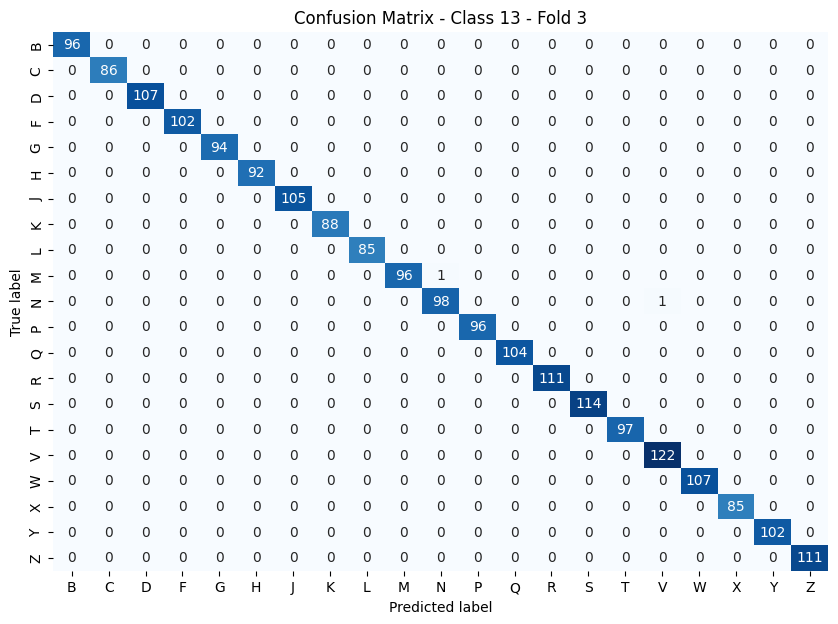

Clase 14 - Fold 3:
TP: 114, FP: 0, FN: 0, TN: 1986


<Figure size 640x480 with 0 Axes>

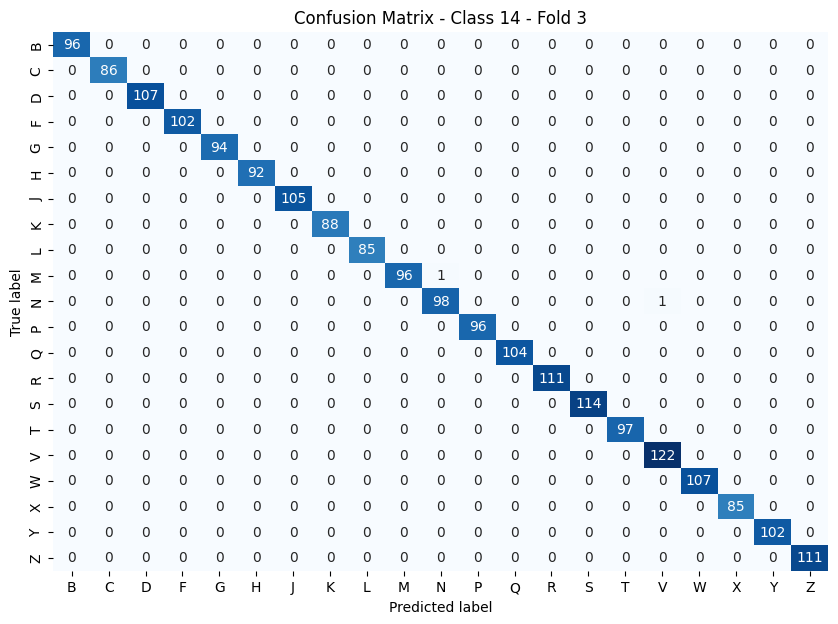

Clase 15 - Fold 3:
TP: 97, FP: 0, FN: 0, TN: 2003


<Figure size 640x480 with 0 Axes>

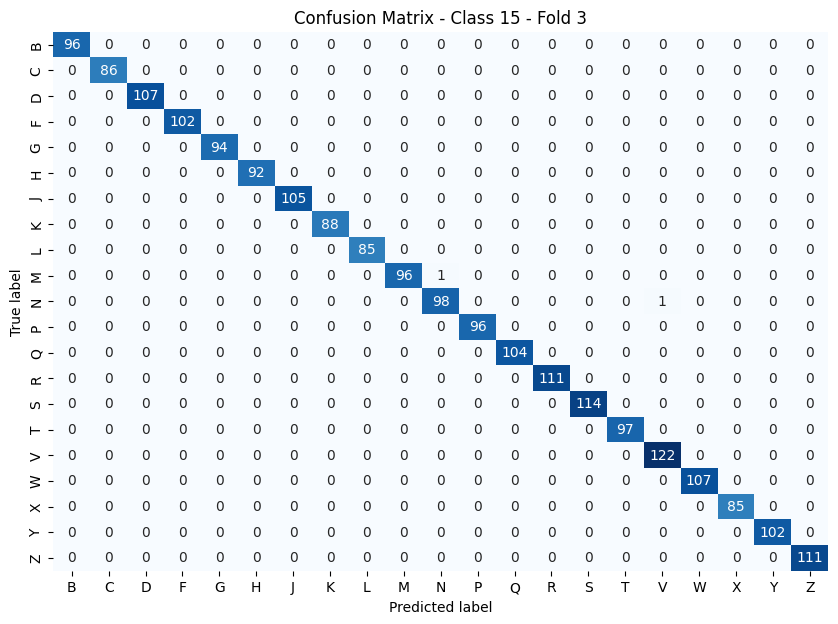

Clase 16 - Fold 3:
TP: 122, FP: 1, FN: 0, TN: 1977


<Figure size 640x480 with 0 Axes>

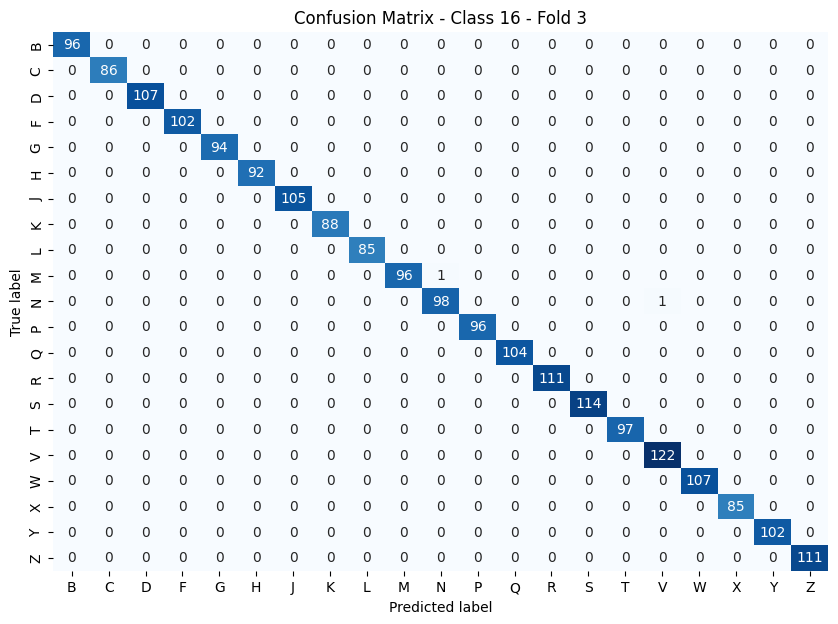

Clase 17 - Fold 3:
TP: 107, FP: 0, FN: 0, TN: 1993


<Figure size 640x480 with 0 Axes>

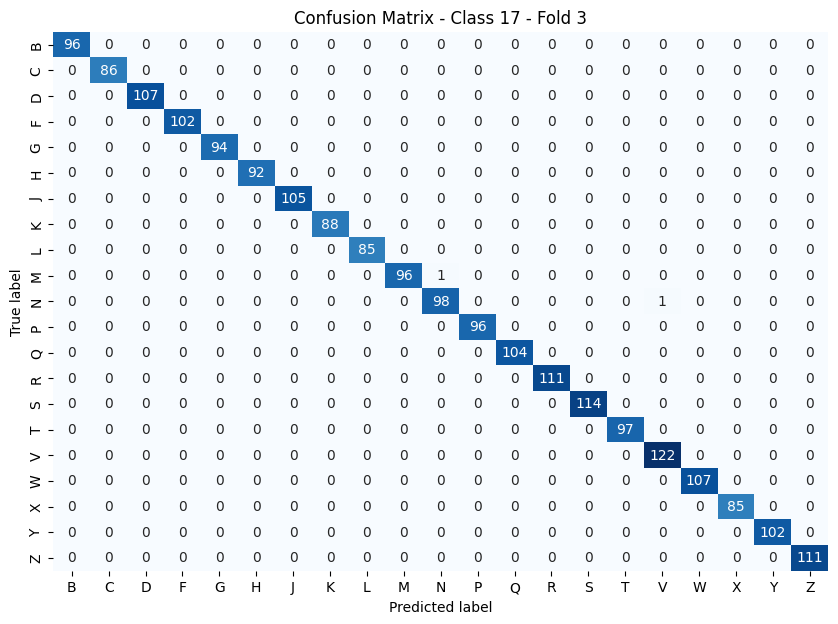

Clase 18 - Fold 3:
TP: 85, FP: 0, FN: 0, TN: 2015


<Figure size 640x480 with 0 Axes>

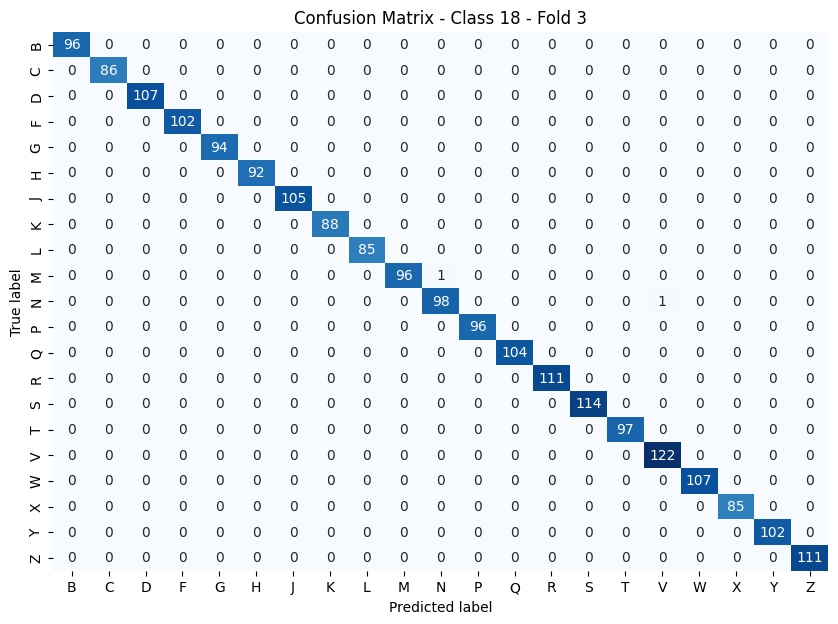

Clase 19 - Fold 3:
TP: 102, FP: 0, FN: 0, TN: 1998


<Figure size 640x480 with 0 Axes>

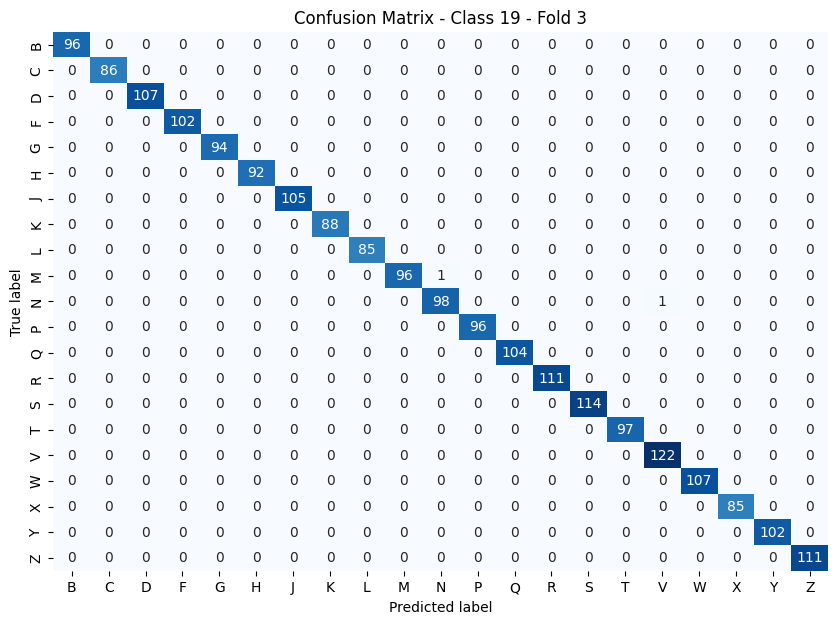

Clase 20 - Fold 3:
TP: 111, FP: 0, FN: 0, TN: 1989


<Figure size 640x480 with 0 Axes>

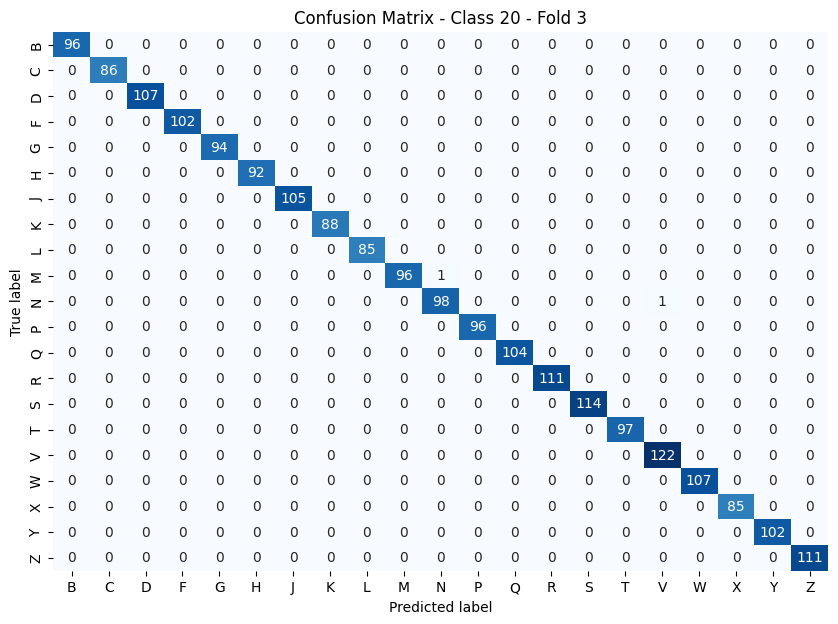

Fold 4/5
Clase 0 - Fold 4:
TP: 97, FP: 0, FN: 0, TN: 2003


<Figure size 640x480 with 0 Axes>

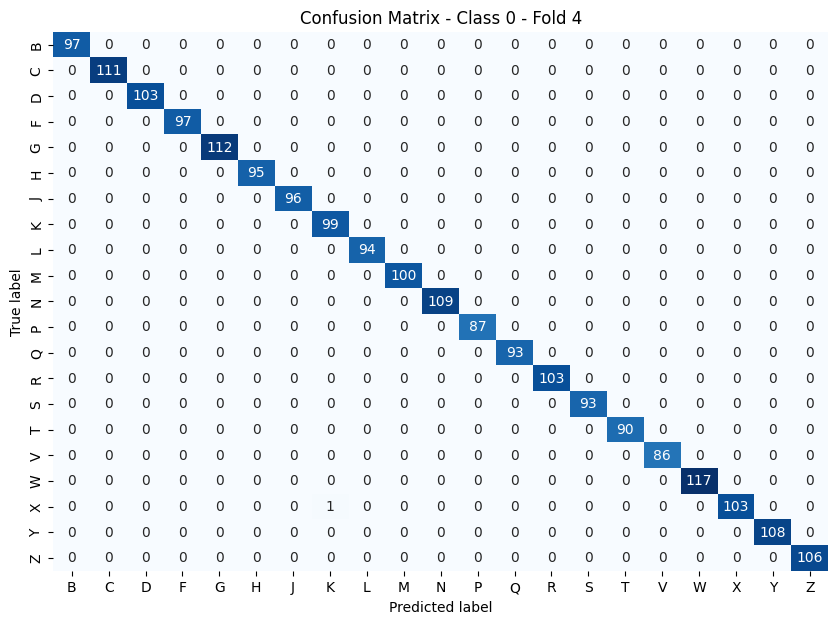

Clase 1 - Fold 4:
TP: 111, FP: 0, FN: 0, TN: 1989


<Figure size 640x480 with 0 Axes>

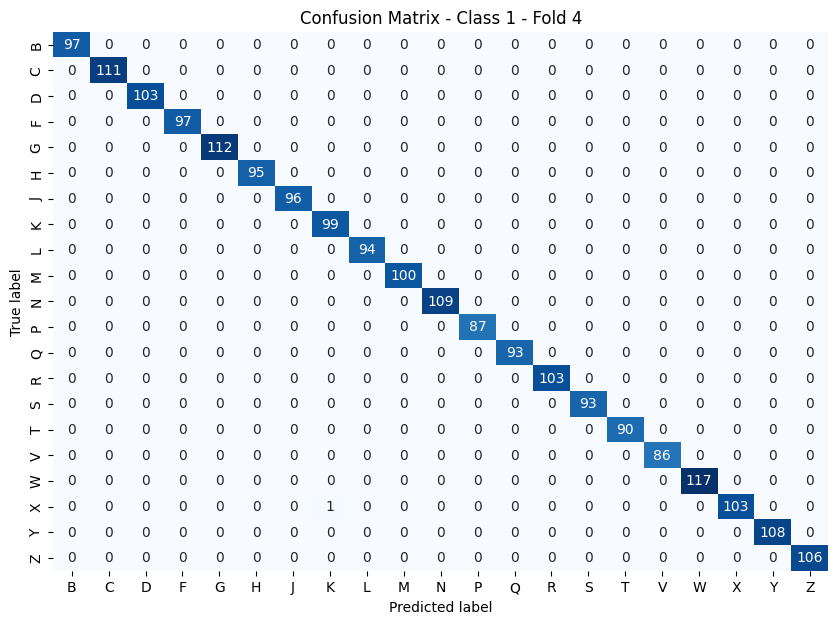

Clase 2 - Fold 4:
TP: 103, FP: 0, FN: 0, TN: 1997


<Figure size 640x480 with 0 Axes>

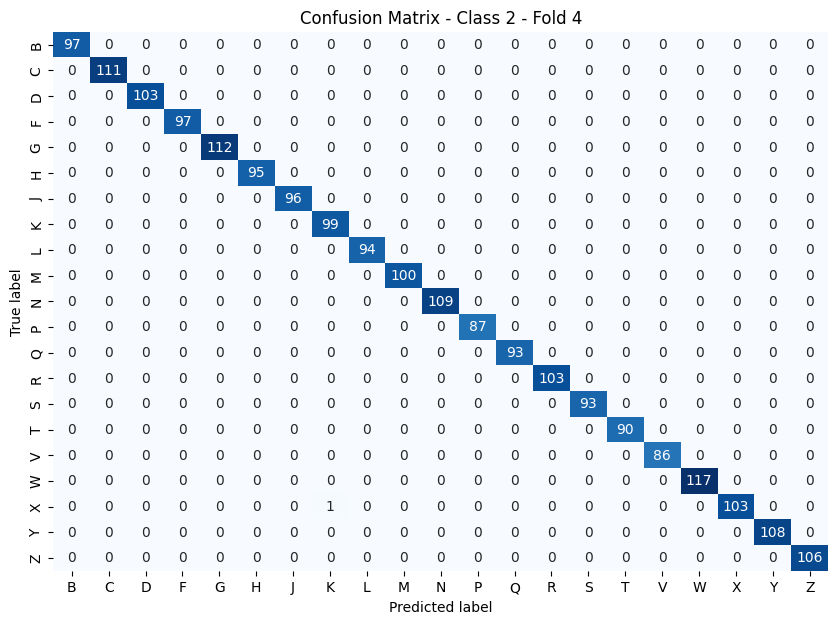

Clase 3 - Fold 4:
TP: 97, FP: 0, FN: 0, TN: 2003


<Figure size 640x480 with 0 Axes>

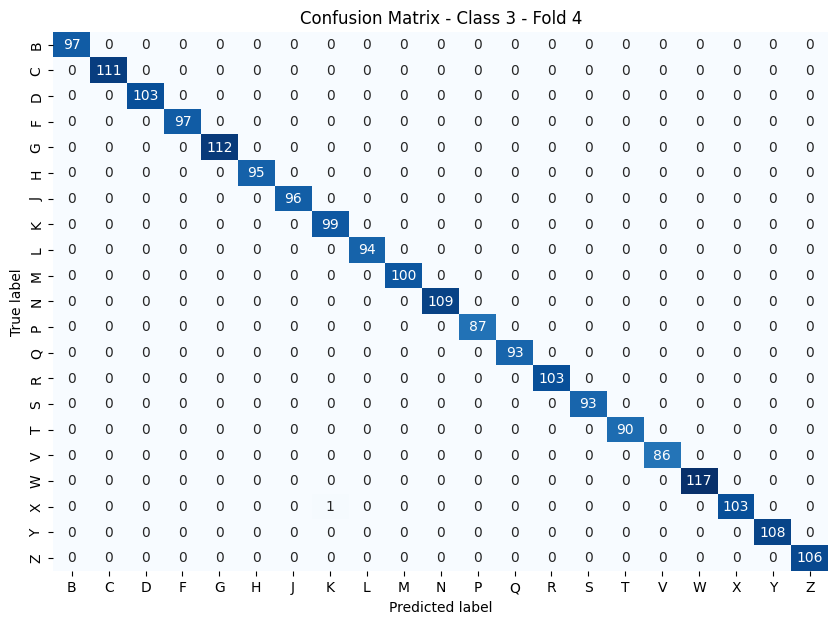

Clase 4 - Fold 4:
TP: 112, FP: 0, FN: 0, TN: 1988


<Figure size 640x480 with 0 Axes>

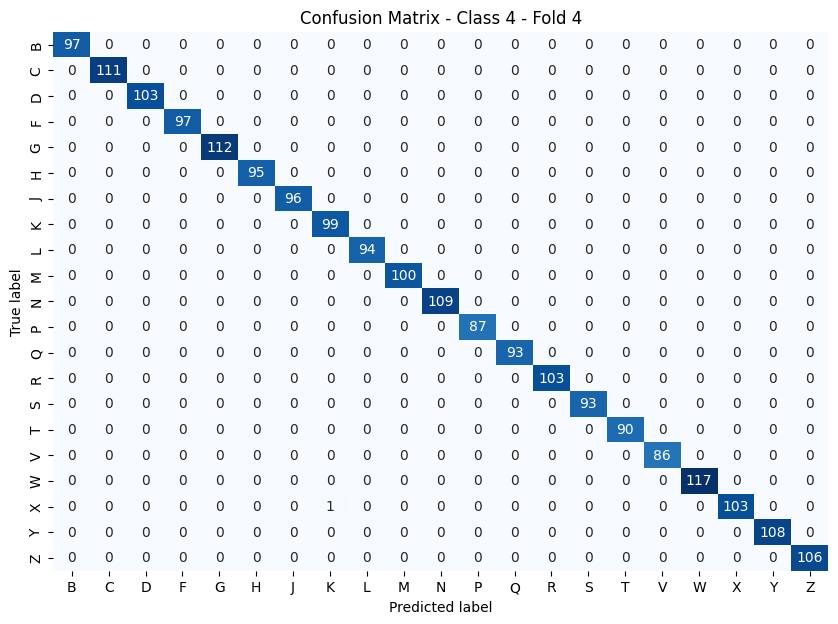

Clase 5 - Fold 4:
TP: 95, FP: 0, FN: 0, TN: 2005


<Figure size 640x480 with 0 Axes>

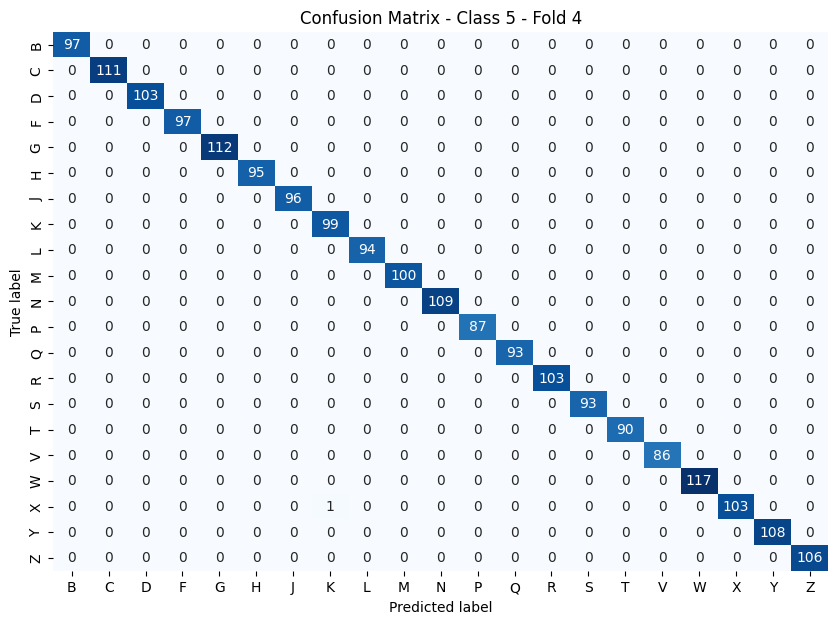

Clase 6 - Fold 4:
TP: 96, FP: 0, FN: 0, TN: 2004


<Figure size 640x480 with 0 Axes>

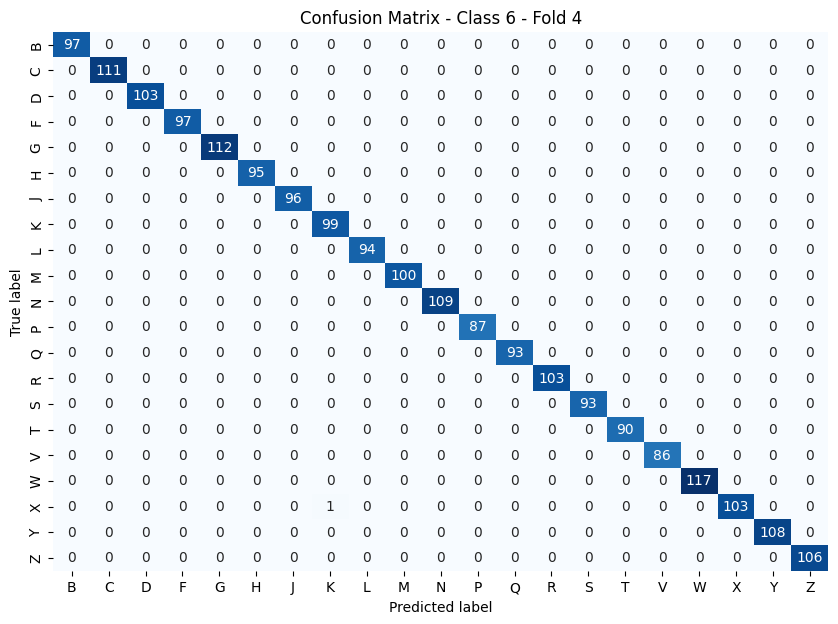

Clase 7 - Fold 4:
TP: 99, FP: 1, FN: 0, TN: 2000


<Figure size 640x480 with 0 Axes>

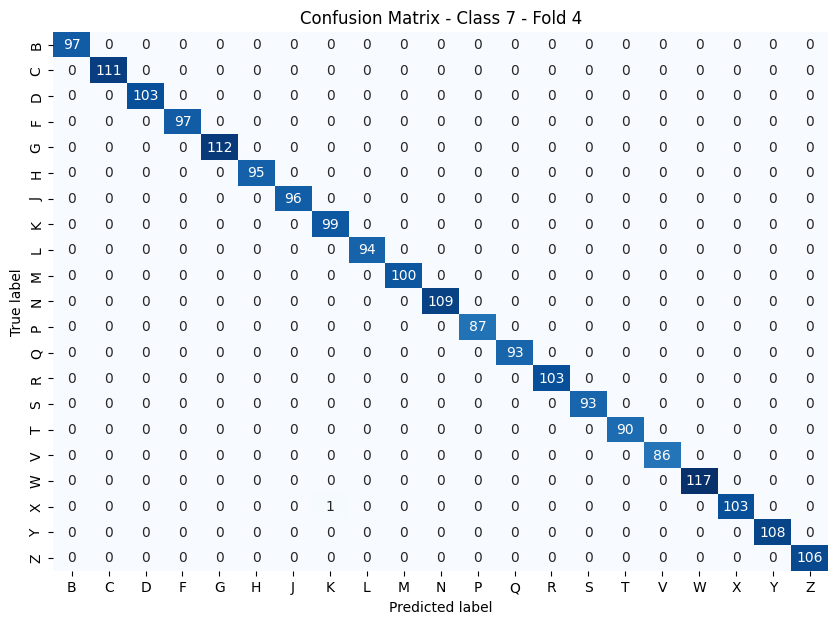

Clase 8 - Fold 4:
TP: 94, FP: 0, FN: 0, TN: 2006


<Figure size 640x480 with 0 Axes>

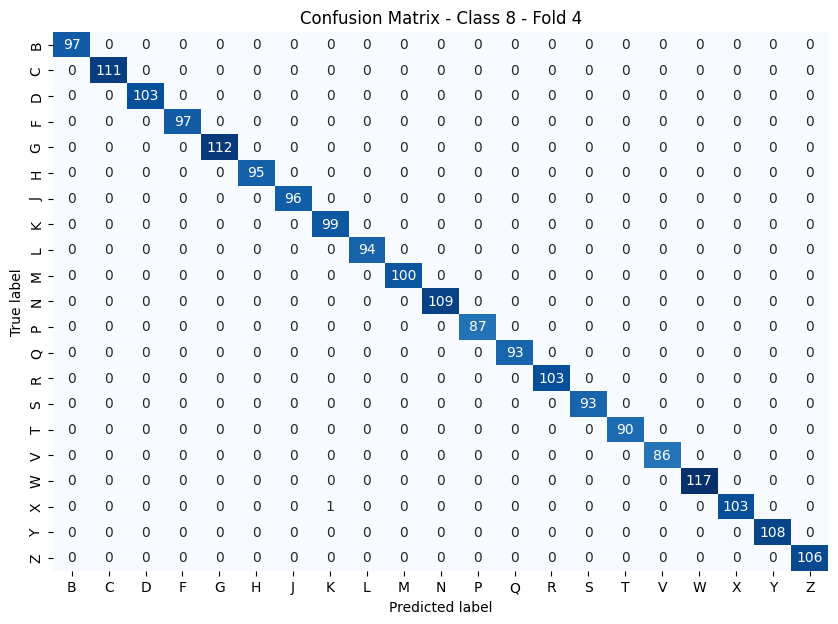

Clase 9 - Fold 4:
TP: 100, FP: 0, FN: 0, TN: 2000


<Figure size 640x480 with 0 Axes>

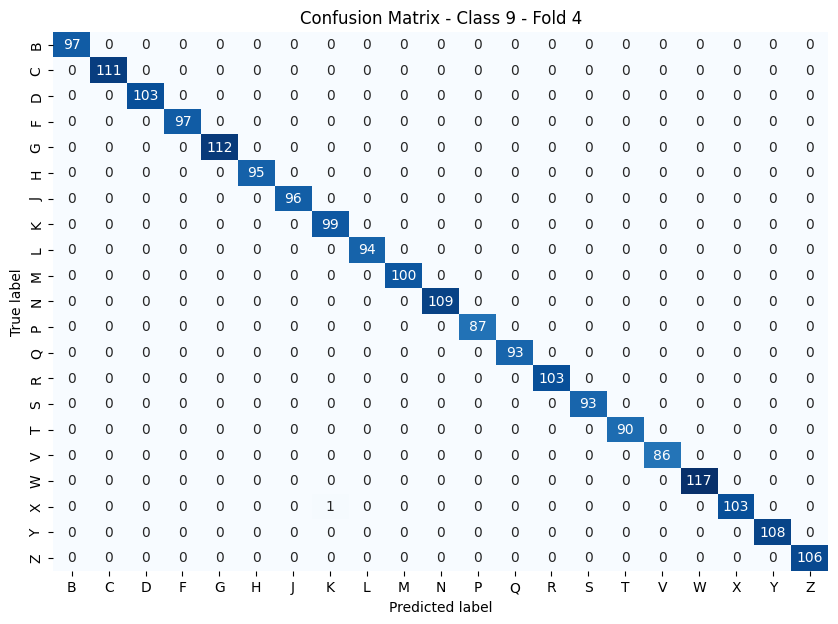

Clase 10 - Fold 4:
TP: 109, FP: 0, FN: 0, TN: 1991


<Figure size 640x480 with 0 Axes>

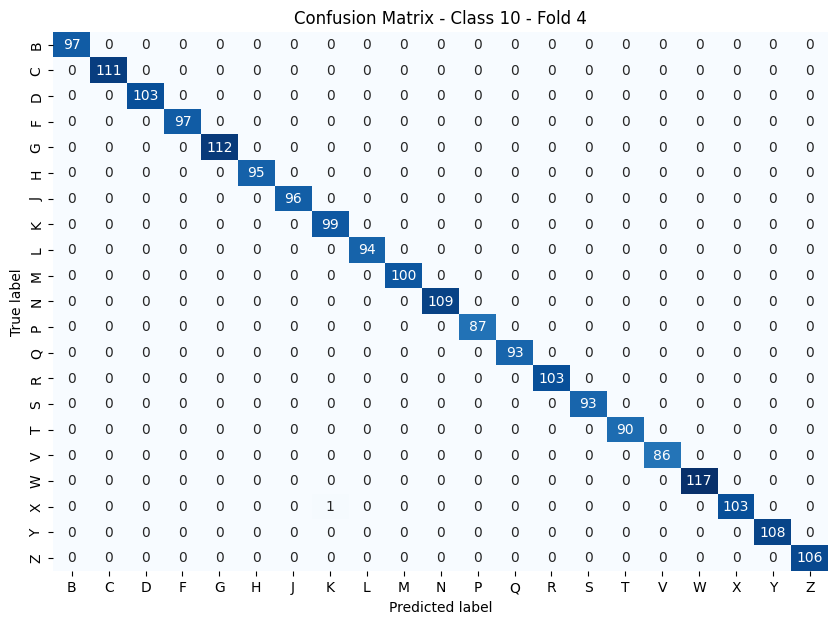

Clase 11 - Fold 4:
TP: 87, FP: 0, FN: 0, TN: 2013


<Figure size 640x480 with 0 Axes>

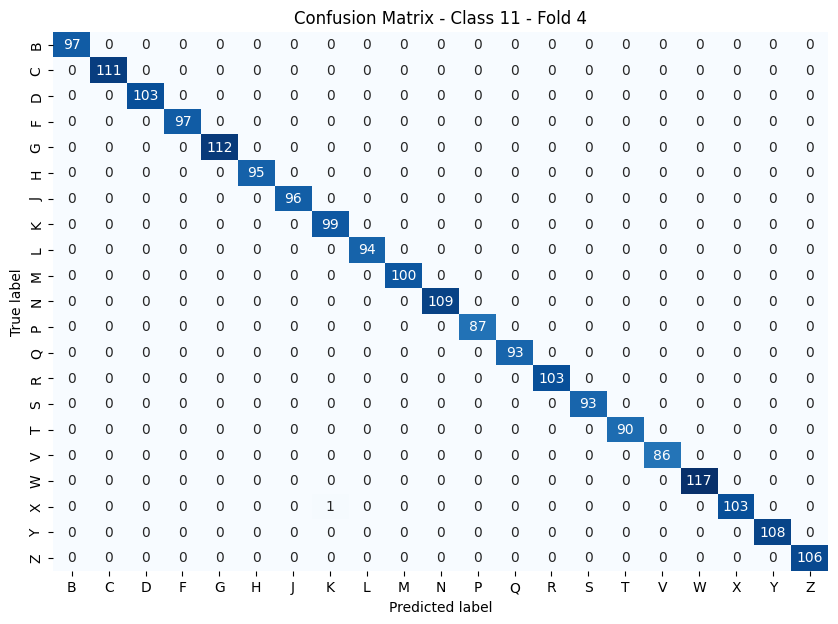

Clase 12 - Fold 4:
TP: 93, FP: 0, FN: 0, TN: 2007


<Figure size 640x480 with 0 Axes>

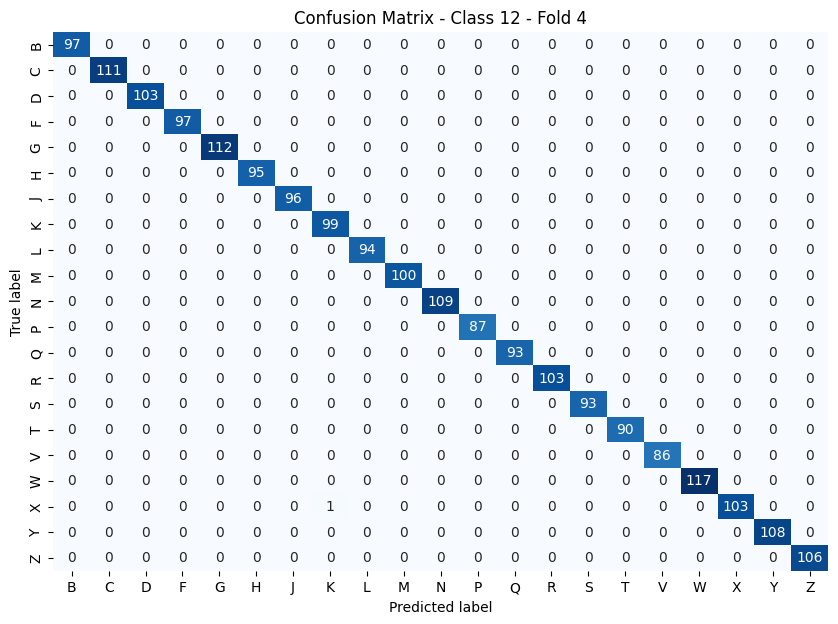

Clase 13 - Fold 4:
TP: 103, FP: 0, FN: 0, TN: 1997


<Figure size 640x480 with 0 Axes>

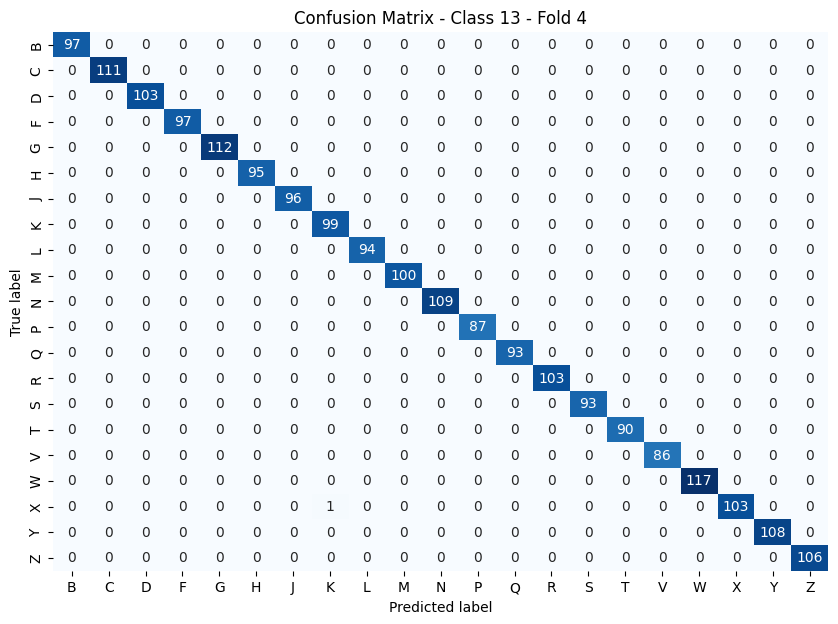

Clase 14 - Fold 4:
TP: 93, FP: 0, FN: 0, TN: 2007


<Figure size 640x480 with 0 Axes>

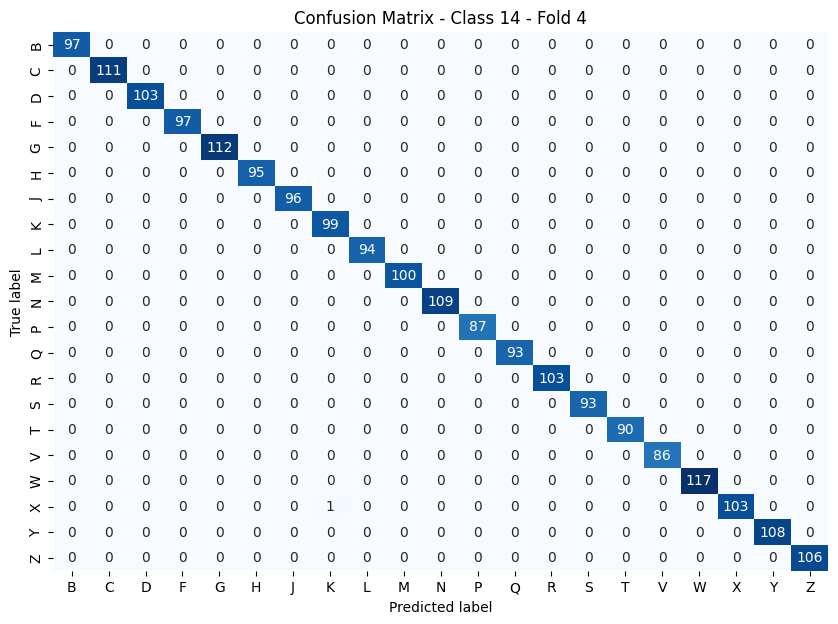

Clase 15 - Fold 4:
TP: 90, FP: 0, FN: 0, TN: 2010


<Figure size 640x480 with 0 Axes>

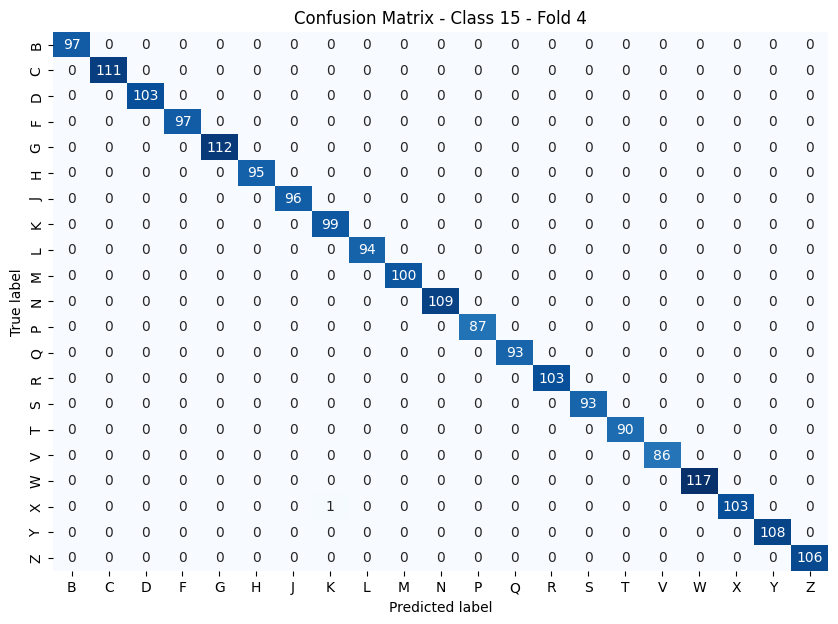

Clase 16 - Fold 4:
TP: 86, FP: 0, FN: 0, TN: 2014


<Figure size 640x480 with 0 Axes>

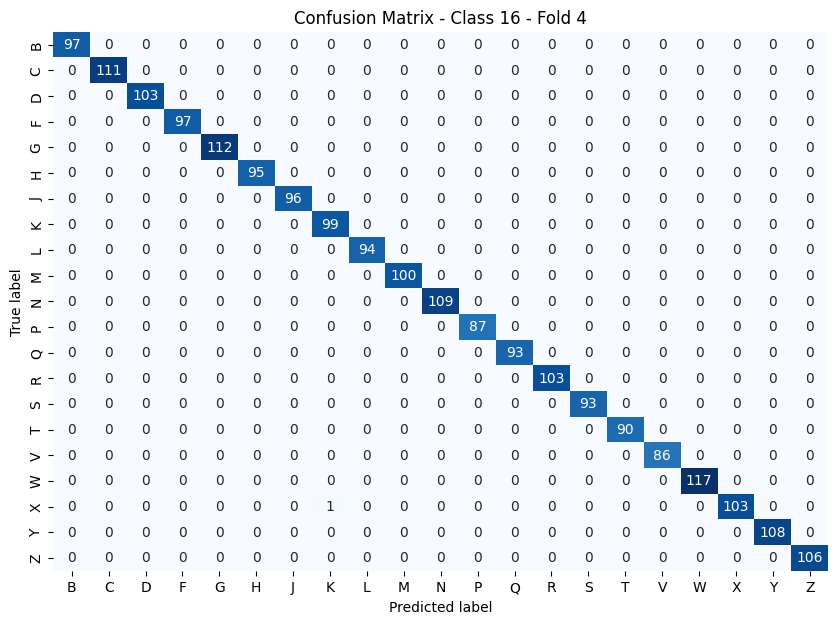

Clase 17 - Fold 4:
TP: 117, FP: 0, FN: 0, TN: 1983


<Figure size 640x480 with 0 Axes>

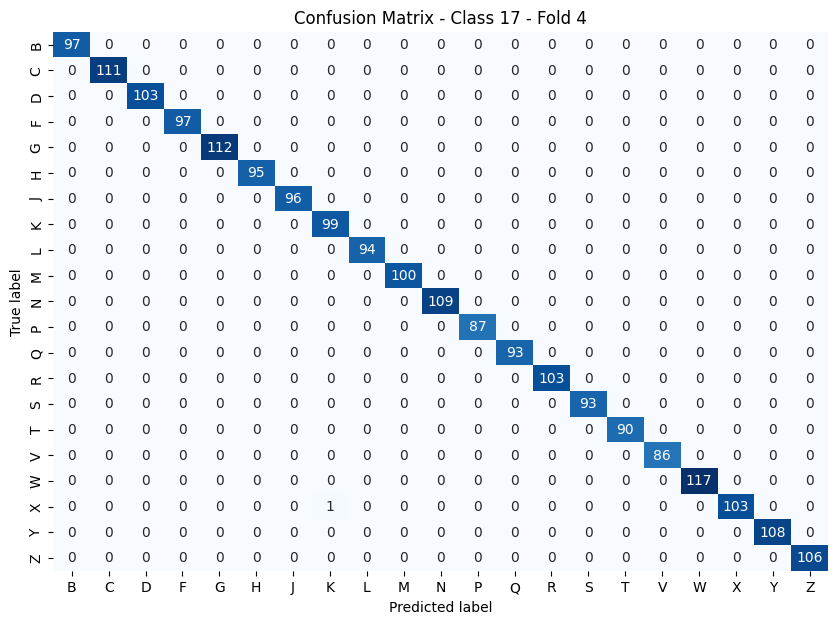

Clase 18 - Fold 4:
TP: 103, FP: 0, FN: 1, TN: 1996


<Figure size 640x480 with 0 Axes>

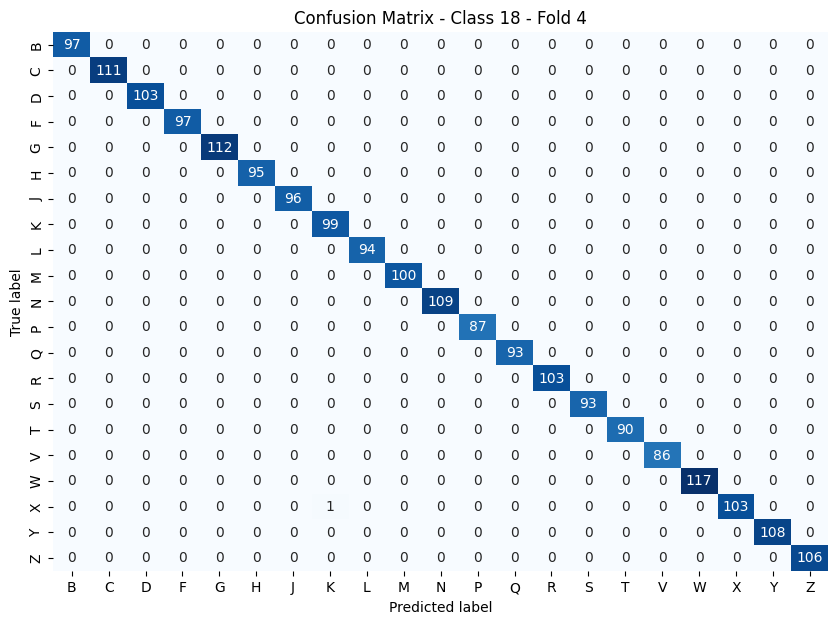

Clase 19 - Fold 4:
TP: 108, FP: 0, FN: 0, TN: 1992


<Figure size 640x480 with 0 Axes>

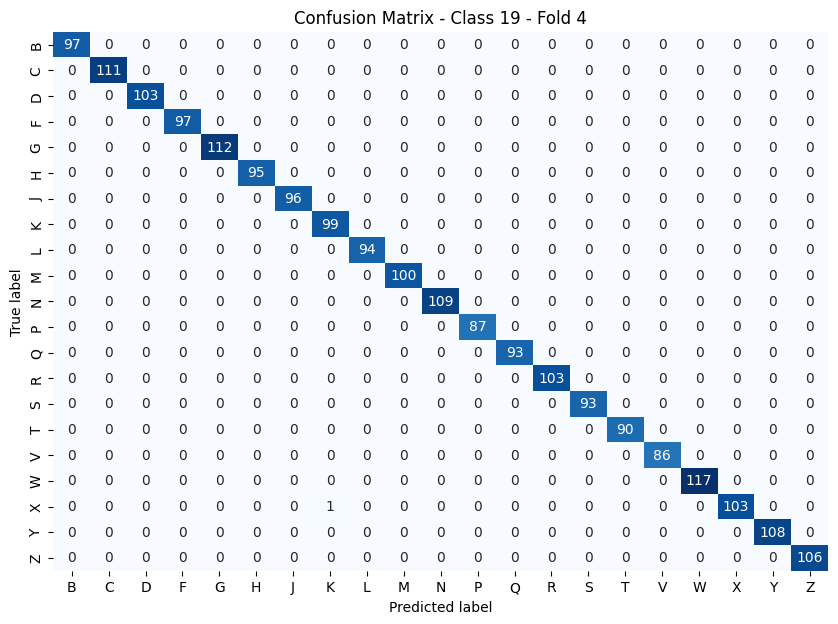

Clase 20 - Fold 4:
TP: 106, FP: 0, FN: 0, TN: 1994


<Figure size 640x480 with 0 Axes>

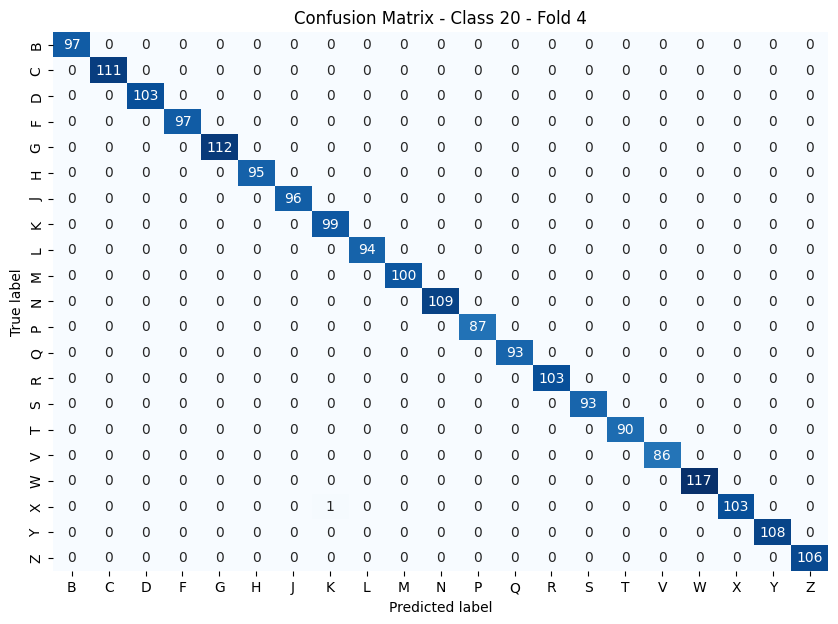

Fold 5/5
Clase 0 - Fold 5:
TP: 91, FP: 0, FN: 0, TN: 2009


<Figure size 640x480 with 0 Axes>

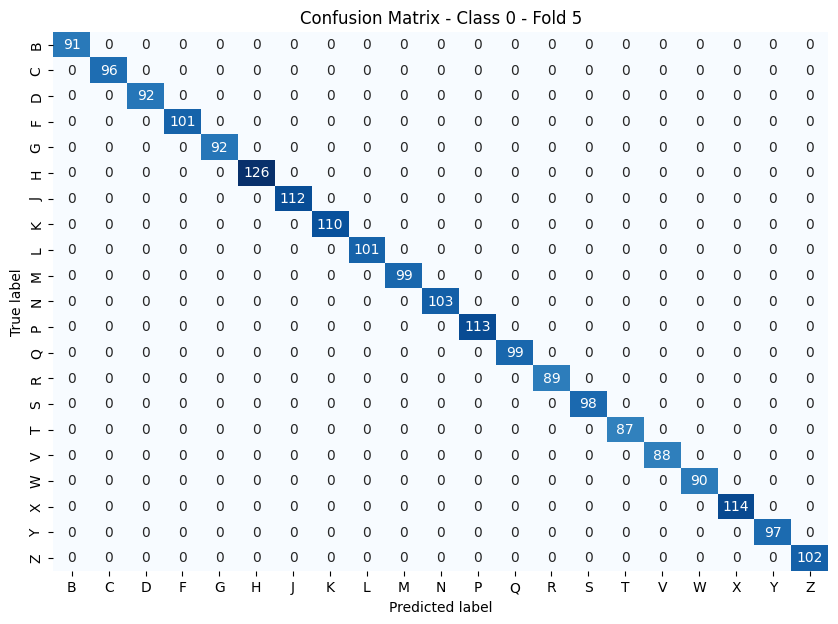

Clase 1 - Fold 5:
TP: 96, FP: 0, FN: 0, TN: 2004


<Figure size 640x480 with 0 Axes>

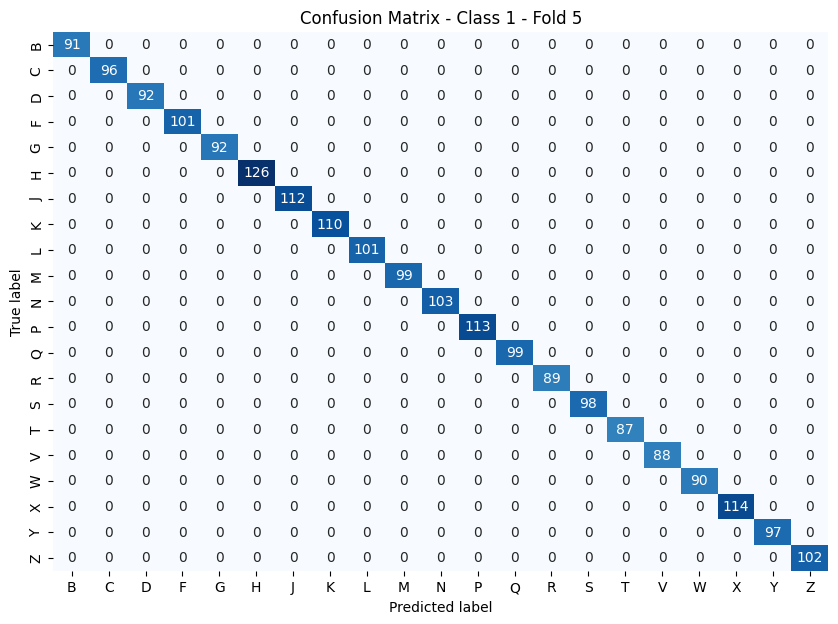

Clase 2 - Fold 5:
TP: 92, FP: 0, FN: 0, TN: 2008


<Figure size 640x480 with 0 Axes>

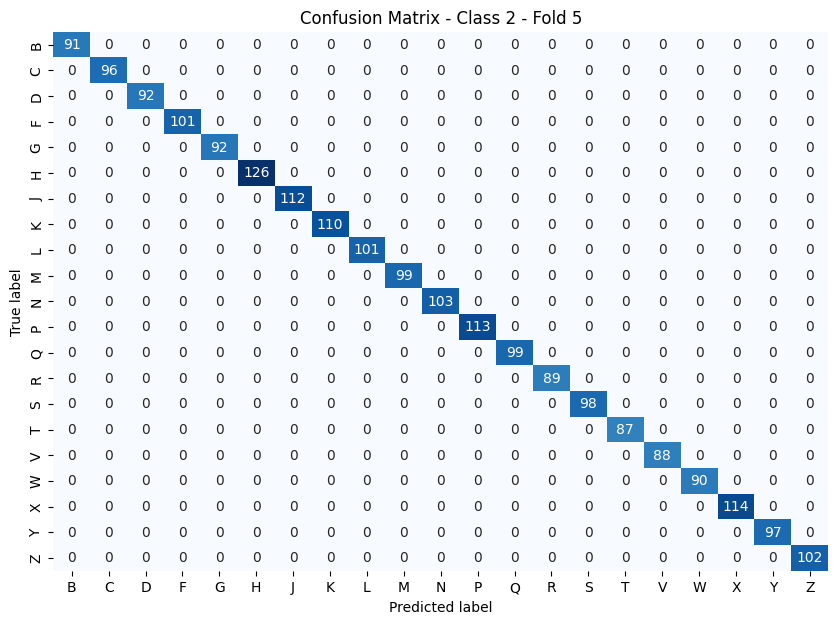

Clase 3 - Fold 5:
TP: 101, FP: 0, FN: 0, TN: 1999


<Figure size 640x480 with 0 Axes>

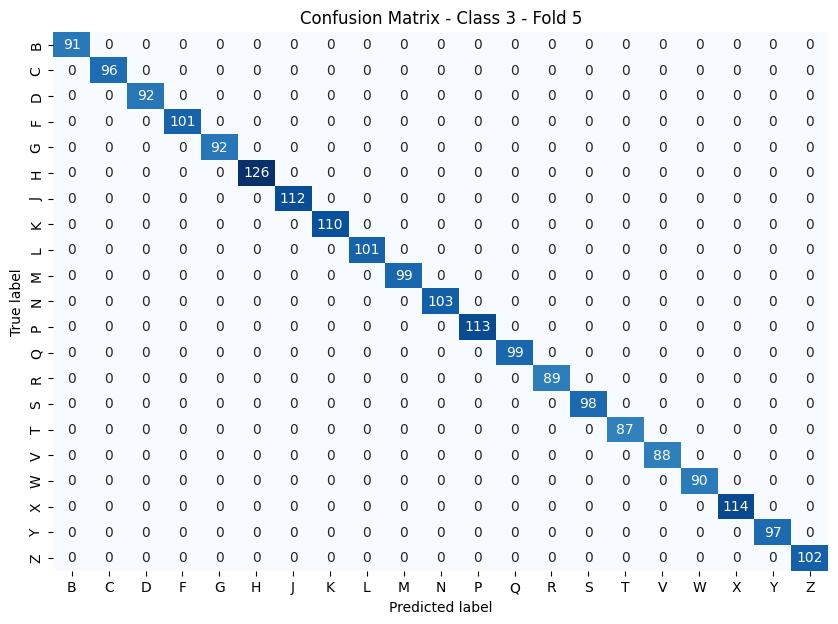

Clase 4 - Fold 5:
TP: 92, FP: 0, FN: 0, TN: 2008


<Figure size 640x480 with 0 Axes>

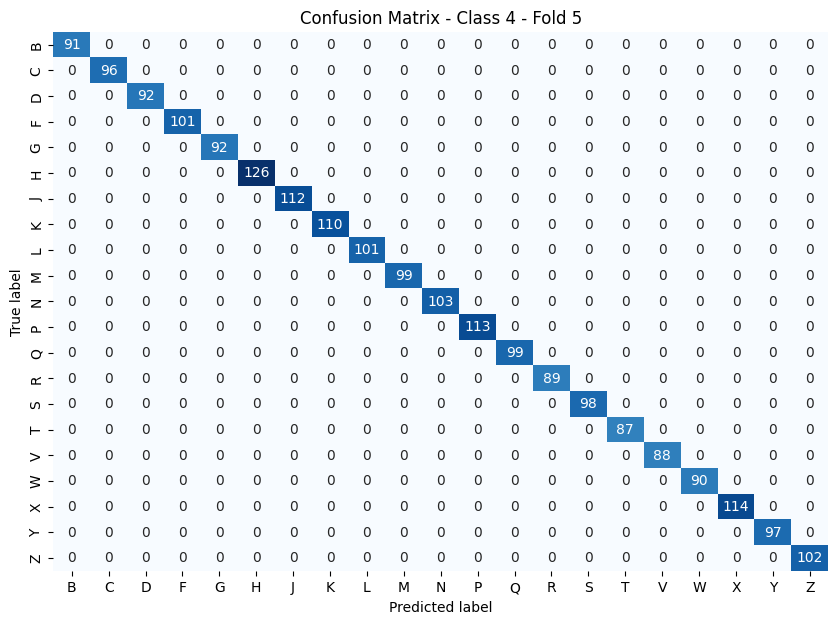

Clase 5 - Fold 5:
TP: 126, FP: 0, FN: 0, TN: 1974


<Figure size 640x480 with 0 Axes>

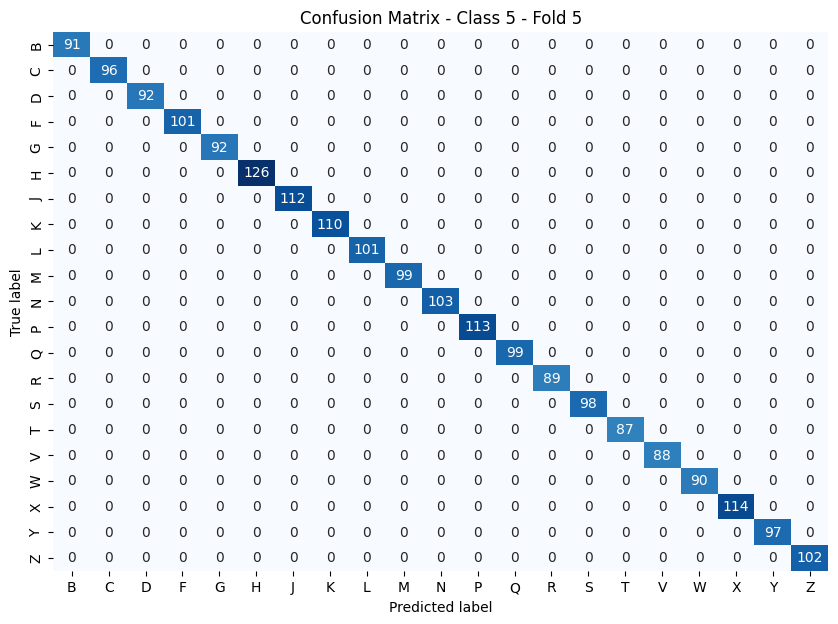

Clase 6 - Fold 5:
TP: 112, FP: 0, FN: 0, TN: 1988


<Figure size 640x480 with 0 Axes>

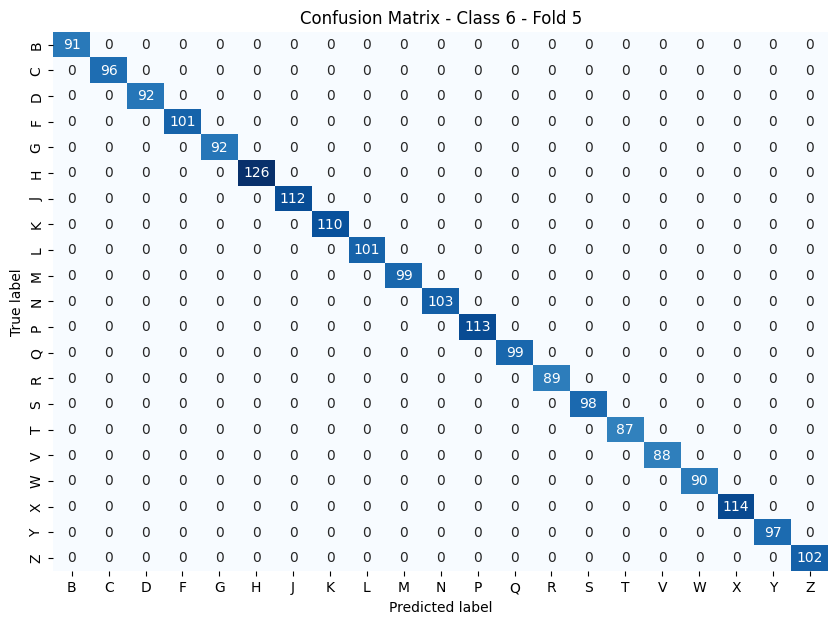

Clase 7 - Fold 5:
TP: 110, FP: 0, FN: 0, TN: 1990


<Figure size 640x480 with 0 Axes>

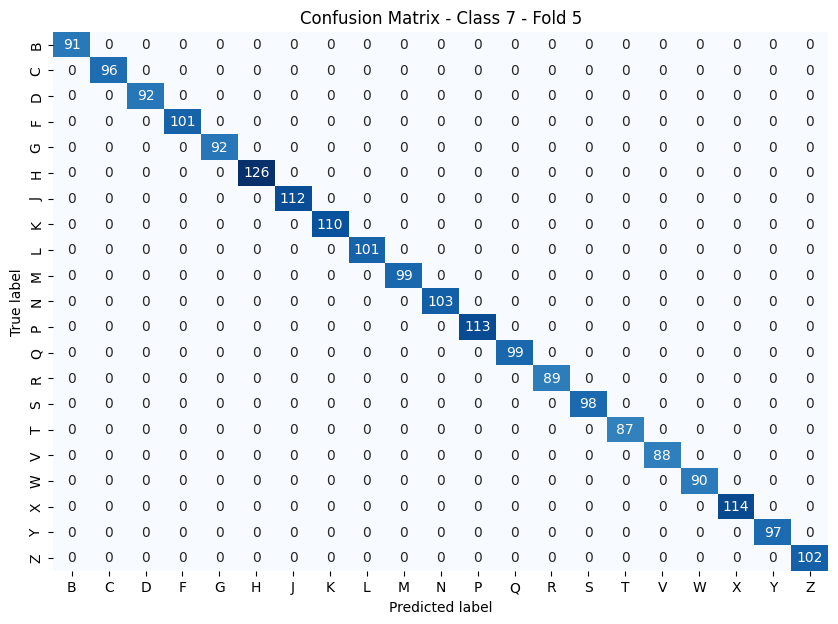

Clase 8 - Fold 5:
TP: 101, FP: 0, FN: 0, TN: 1999


<Figure size 640x480 with 0 Axes>

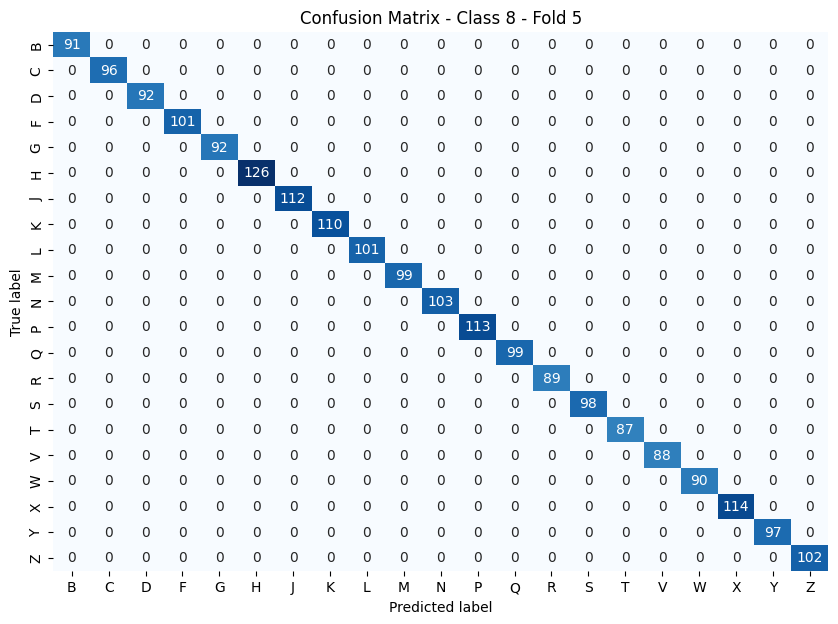

Clase 9 - Fold 5:
TP: 99, FP: 0, FN: 0, TN: 2001


<Figure size 640x480 with 0 Axes>

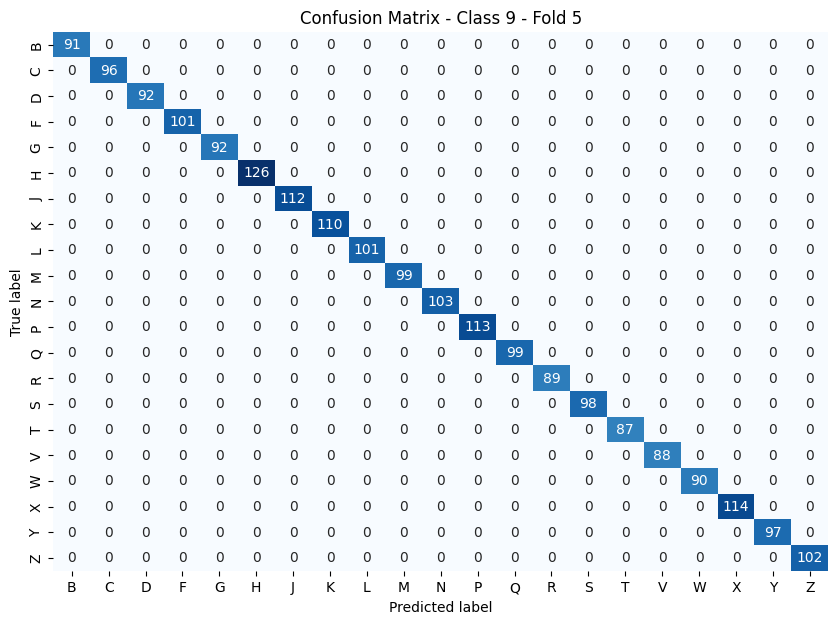

Clase 10 - Fold 5:
TP: 103, FP: 0, FN: 0, TN: 1997


<Figure size 640x480 with 0 Axes>

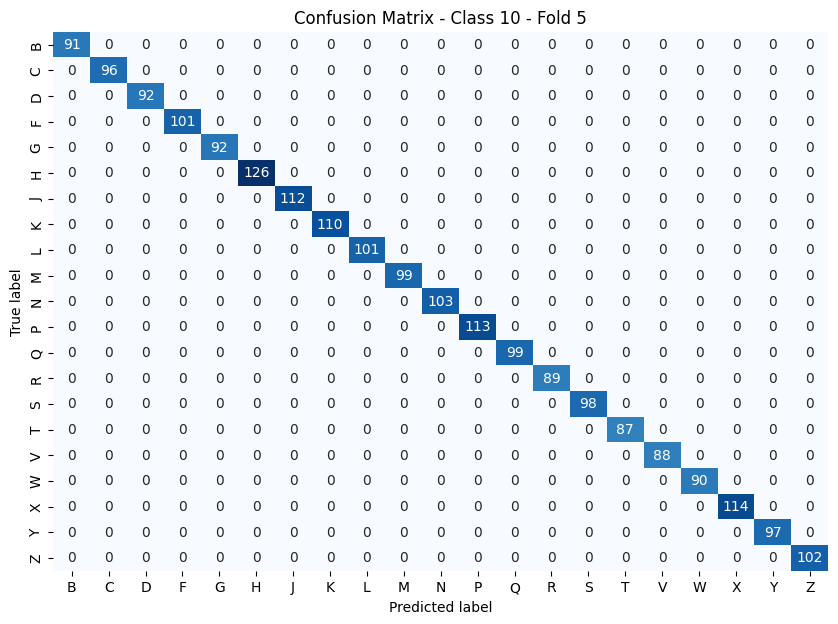

Clase 11 - Fold 5:
TP: 113, FP: 0, FN: 0, TN: 1987


<Figure size 640x480 with 0 Axes>

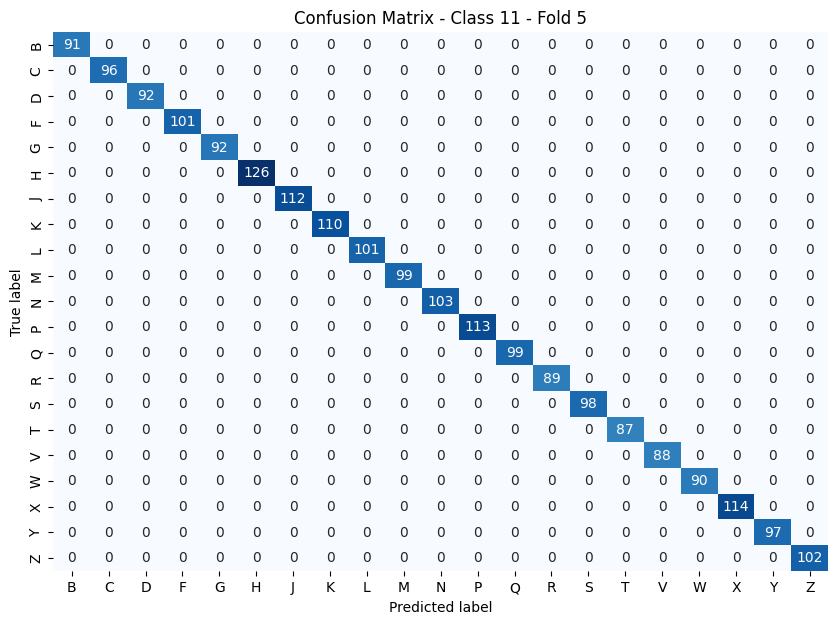

Clase 12 - Fold 5:
TP: 99, FP: 0, FN: 0, TN: 2001


<Figure size 640x480 with 0 Axes>

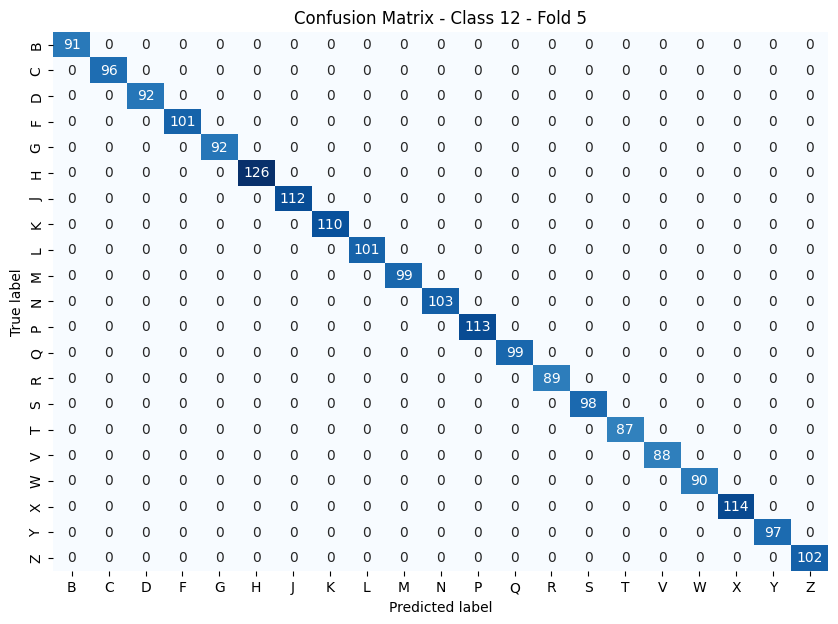

Clase 13 - Fold 5:
TP: 89, FP: 0, FN: 0, TN: 2011


<Figure size 640x480 with 0 Axes>

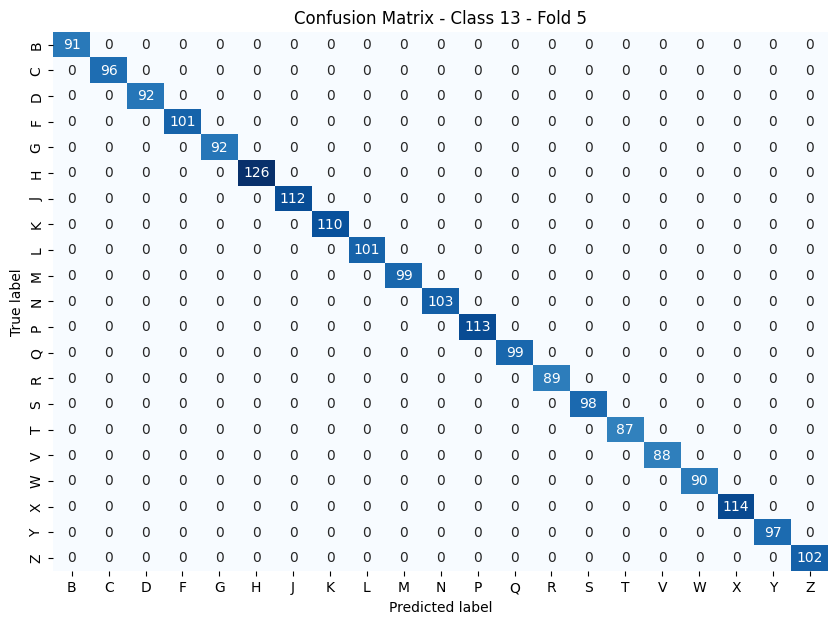

Clase 14 - Fold 5:
TP: 98, FP: 0, FN: 0, TN: 2002


<Figure size 640x480 with 0 Axes>

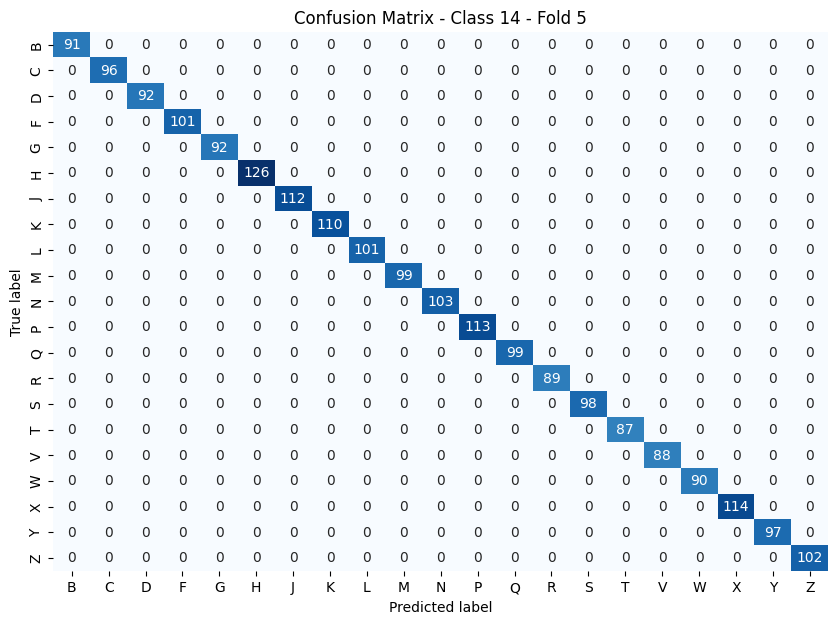

Clase 15 - Fold 5:
TP: 87, FP: 0, FN: 0, TN: 2013


<Figure size 640x480 with 0 Axes>

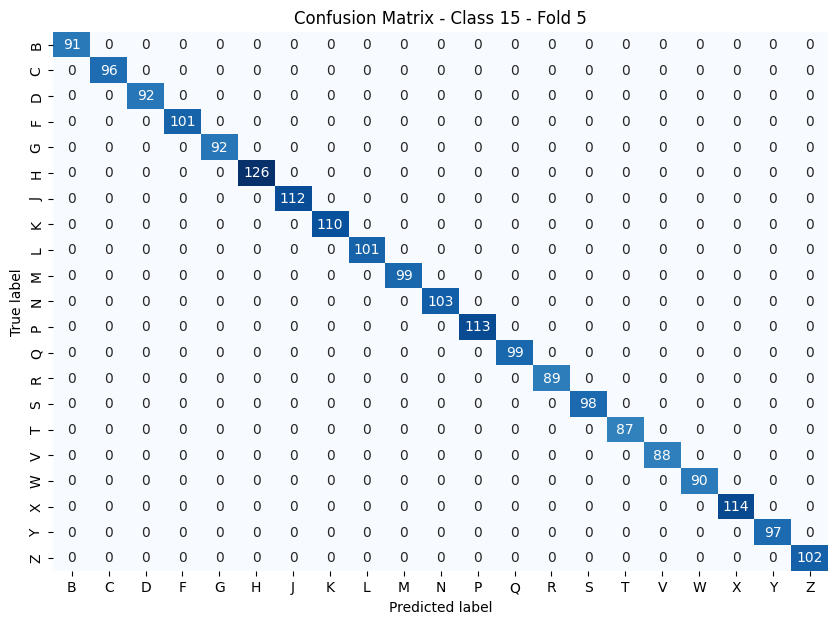

Clase 16 - Fold 5:
TP: 88, FP: 0, FN: 0, TN: 2012


<Figure size 640x480 with 0 Axes>

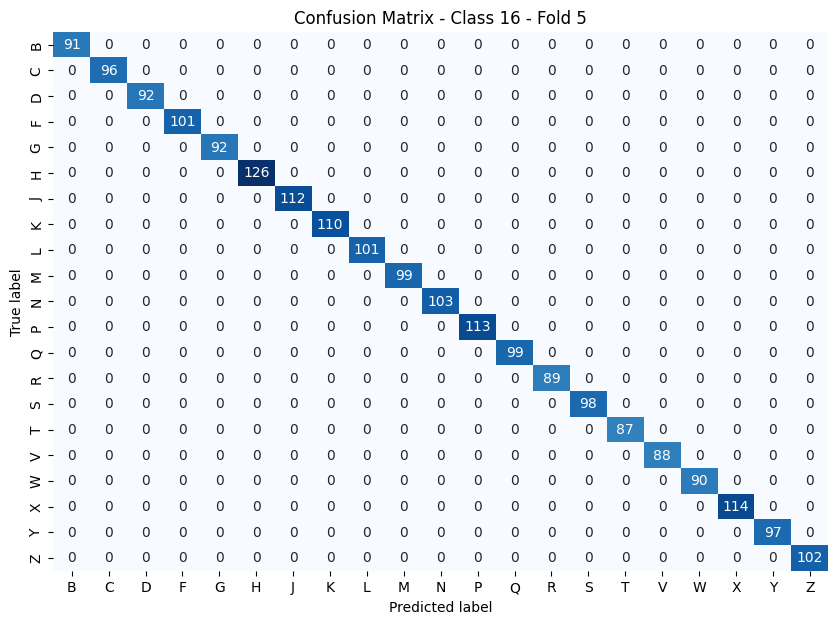

Clase 17 - Fold 5:
TP: 90, FP: 0, FN: 0, TN: 2010


<Figure size 640x480 with 0 Axes>

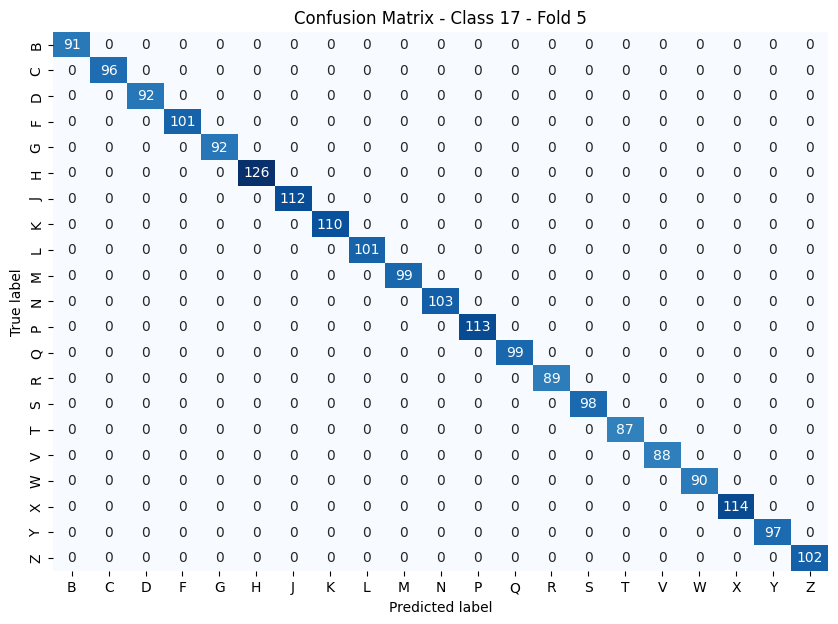

Clase 18 - Fold 5:
TP: 114, FP: 0, FN: 0, TN: 1986


<Figure size 640x480 with 0 Axes>

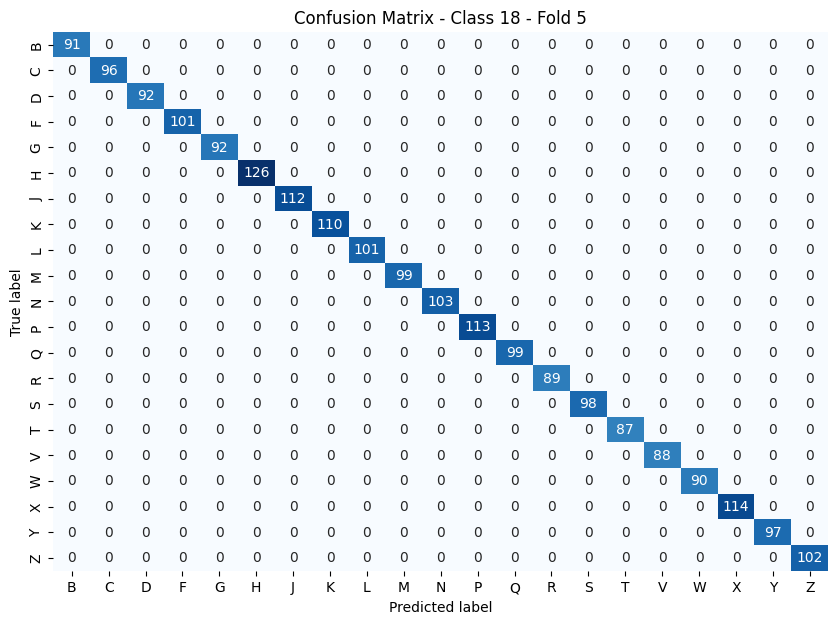

Clase 19 - Fold 5:
TP: 97, FP: 0, FN: 0, TN: 2003


<Figure size 640x480 with 0 Axes>

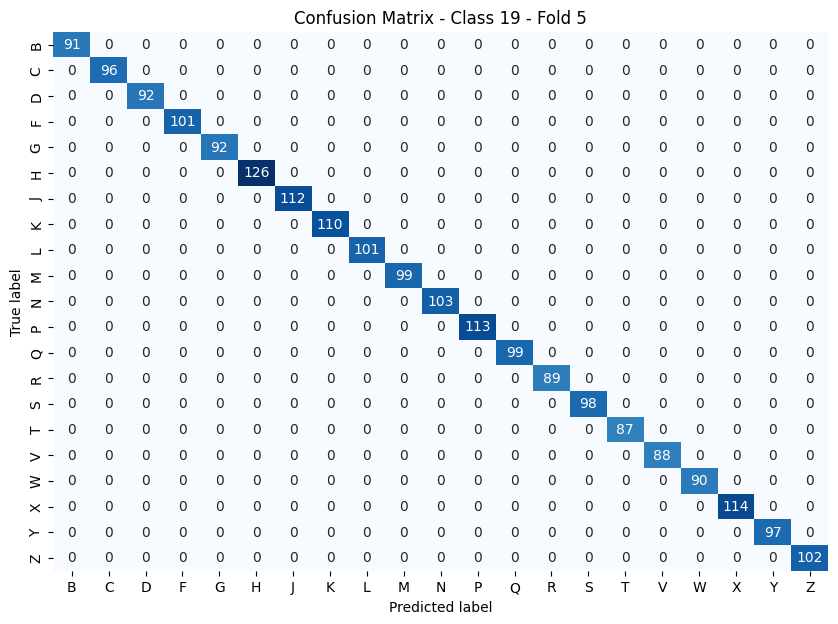

Clase 20 - Fold 5:
TP: 102, FP: 0, FN: 0, TN: 1998


<Figure size 640x480 with 0 Axes>

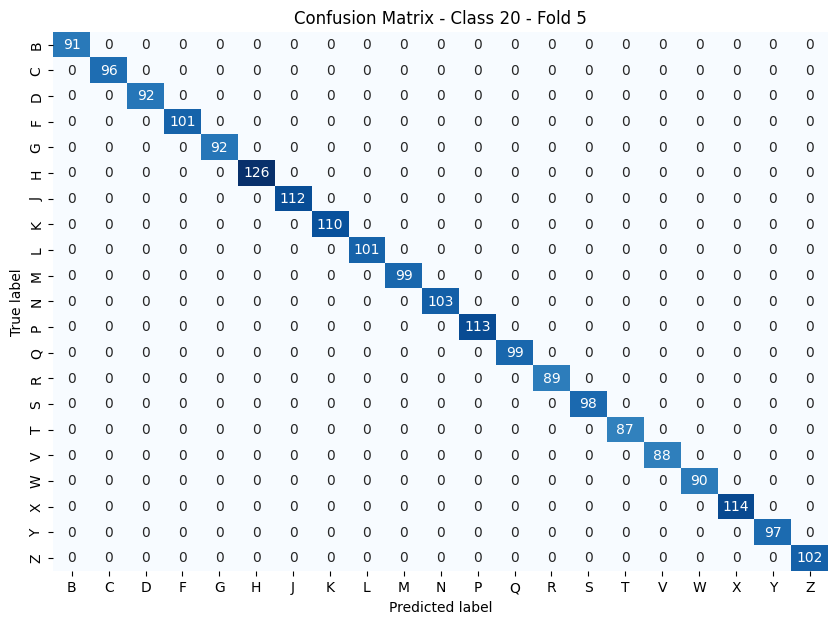

<Figure size 640x480 with 0 Axes>

In [9]:
# Loop a través de los pliegues
for fold, (train_indices, val_indices) in enumerate(kfold.split(range(len(dataset)))):
    print(f'Fold {fold + 1}/{num_folds}')

    # Crear subconjuntos de entrenamiento y validación
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)

    # Crear DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Mover el modelo a la GPU
    model.to('cuda')

    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validación
    model.eval()
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

    # Obtener la matriz de confusión completa
    cm = confusion_matrix(val_labels, val_predictions)
    num_classes = len(dataset.classes)

    # Para cada clase (número), calculamos TP, FP, FN, TN
    for class_idx in range(num_classes):
        # Verdaderos Positivos (TP): Valor en la diagonal de la matriz para la clase actual
        TP = cm[class_idx, class_idx]

        # Falsos Positivos (FP): Suma de la columna de la clase, excepto el TP
        FP = cm[:, class_idx].sum() - TP

        # Falsos Negativos (FN): Suma de la fila de la clase, excepto el TP
        FN = cm[class_idx, :].sum() - TP

        # Verdaderos Negativos (TN): Todo lo que no está en la fila ni en la columna de la clase
        TN = cm.sum() - (TP + FP + FN)

        # Crear la carpeta 'results' si no existe antes de guardar cada archivo
        results_dir = 'results'
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        # Guardar TP, FP, TN, FN en un archivo dentro de la carpeta 'results'
        file_path = os.path.join(results_dir, f'confusion_matrix_metrics_class_{class_idx}_fold_{fold + 1}.txt')

        with open(file_path, 'w') as f:
            f.write(f'Clase {class_idx}:\n')
            f.write(f'TP: {TP}\n')
            f.write(f'FP: {FP}\n')
            f.write(f'FN: {FN}\n')
            f.write(f'TN: {TN}\n')

        print(f'Clase {class_idx} - Fold {fold + 1}:')
        print(f'TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}')

        # Visualizar la matriz de confusión completa
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=dataset.classes, yticklabels=dataset.classes)
        plt.title(f'Confusion Matrix - Class {class_idx} - Fold {fold + 1}')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        # Guardar la figura
        wandb.log({f"confusion_matrix_class_{class_idx}_fold_{fold + 1}": wandb.Image(plt)})
        plt.show()
        plt.clf()  # Limpiar la figura para la próxima iteración

In [10]:
# Finaliza la sesión de WandB
wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

In [11]:
model_save_path = f'model_letter_classifier_cnn.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to model_letter_classifier_cnn.pth


In [12]:
import zipfile
import os

def zip_folder(folder_path, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Recorrer todos los archivos y carpetas dentro de folder_path
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                # Escribir cada archivo al ZIP usando un path relativo
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Ruta de la carpeta que quieres comprimir
folder_to_zip = 'results'

# Nombre del archivo zip de salida
output_zip_file = 'results_CMF_CNN_Letters.zip'

# Llamar a la función para crear el zip
zip_folder(folder_to_zip, output_zip_file)

print(f"Carpeta '{folder_to_zip}' comprimida en '{output_zip_file}'")


Carpeta 'results' comprimida en 'results_CMF_CNN_Letters.zip'
